# CS439 Final Project - TDA + ML for Food Desert Prediction
## Complete Cleaned Notebook with Data Validation and Exploration - focused on NJ
Denise Gonzalez-Cruz,   netid: dg1070,    section: 08

This notebook combines:
1. Data loading and cleaning with proper FIPS handling
2. Comprehensive validation and quality checks
3. Dataset relationship exploration
4. TDA pipeline with GUDHI
5. ML model building

Key improvements:
- Fixed FIPS code padding issues
- Handles missing value codes (-9999, -8888)
- Validates all merge operations
- Shows county-level vs tract-level data limitations
- Provides detailed data quality reports

Reasoning for choosing NJ: 
- Chosen as a starting point since we are currently in NJ
- wanted to see how NJ would perform in terms of food insecurity 
- found that NJ is densely populated, so overall, doesn't have the highest rates of food insecurity; Need to conduct TDA and train on different states across the US

In [1]:
import os, time, warnings
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import seaborn as sns

# TDA: GUDHI
USE_GUDHI = True
try:
    import gudhi as gd
    import gudhi.representations as gdr
except Exception as e:
    USE_GUDHI = False
    warnings.warn(f'GUDHI import failed: {e}. Install GUDHI to run the TDA sections.')

import matplotlib.pyplot as plt

In [53]:
# SECTION 1: PARAMETERS AND CONFIGURATION


print("\n" + "="*80)
print("SECTION 1: CONFIGURATION")
print("="*80)

# File paths
STATE_POSTAL = 'NJ'
STATE_FIPS = '34'  # New Jersey
TRACT_LIST_CSV = 'census_tracts_2025.csv'
ACS_CSV = 'ACSST5Y2023.S1901-Data.csv'
FEA_CSV = '2025-food-environment-atlas-data/StateAndCountyData.csv'  # Your USDA atlas file
TIGER_SHP = 'tl_2020_34_tract.shp'  # Will download if needed
OUTPUT_DIR = 'project_outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# TDA parameters
MAX_DIM = 2 # found the issue here - we weren't getting results for H1 because max dim was set to 1 instead of 2 
"""decreasing the number of k_neighbors to reduce computational load - especially since NJ is so densely populated in some areass with many tracts close together"""
K_NEIGHBORS = 8 # may have to minimize since we have many tracts within each , changing to 8 from 12, too computationally expensive

# Distance metric weights
alpha_poverty = 0.2
alpha_income = 0.1
alpha_density = 0.1

# Missing value codes used by USDA
MISSING_CODES = [-9999, -8888, -99999]

print(f"State: {STATE_POSTAL} (FIPS: {STATE_FIPS})")
print(f"Output directory: {OUTPUT_DIR}")
print(f"TDA parameters: MAX_DIM={MAX_DIM}, K_NEIGHBORS={K_NEIGHBORS}")
print(f"Distance weights: poverty={alpha_poverty}, income={alpha_income}, density={alpha_density}")


SECTION 1: CONFIGURATION
State: NJ (FIPS: 34)
Output directory: project_outputs
TDA parameters: MAX_DIM=2, K_NEIGHBORS=8
Distance weights: poverty=0.2, income=0.1, density=0.1


In [54]:
# section 2: data cleaning functions
print("\n" + "="*80)
print("section 2: data cleaning functions")
print("="*80)

def clean_missing_codes(df, missing_codes=MISSING_CODES):
    """replace standard missing value codes with NaN"""
    return df.replace(missing_codes, np.nan)

def standardize_fips(fips_series, target_length=11):
    """Standardize FIPS codes with zero-padding"""
    '''def pad_fips(x):
        if pd.isna(x):
            return x
        x_str = str(int(float(x))) if isinstance(x, (int, float)) else str(x)
        return x_str.zfill(target_length)
    return fips_series.apply(pad_fips)'''
    fips_series = fips_series.astype(str)

    # Remove ACS prefix if present (everything before 'US')
    fips_series = fips_series.str.replace(r'.*US', '', regex=True)

    # Zero‑pad to target length
    fips_series = fips_series.str.zfill(target_length)

    return fips_series

def validate_geoid_format(geoid_series, name="GEOID", expected_length=11):
    """Validate GEOID format and report issues"""
    geoid_str = geoid_series.astype(str)
    lengths = geoid_str.str.len()
    
    print(f"\n{name} Validation (Expected length: {expected_length}):")
    print("-" * 60)
    print(f"  Total records:      {len(geoid_series):>10,}")
    print(f"  Null values:        {geoid_series.isna().sum():>10,}")
    print(f"  Correct length:     {(lengths == expected_length).sum():>10,}")
    print(f"  Incorrect length:   {(lengths != expected_length).sum():>10,}")
    print(f"  Duplicates:         {geoid_series.duplicated().sum():>10,}")
    print(f"  Unique values:      {geoid_series.nunique():>10,}")
    
    if (lengths != expected_length).sum() > 0:
        print("\n  Length distribution:")
        print(lengths.value_counts().sort_index().to_string())

def report_merge_quality(df_before, df_after, merge_name, indicator_col):
    """Report merge quality statistics"""
    print(f"\n{merge_name} Merge Quality:")
    print("-" * 60)
    print(f"  Records before:     {len(df_before):>10,}")
    print(f"  Records after:      {len(df_after):>10,}")
    print(f"  Successful matches: {df_after[indicator_col].notna().sum():>10,}")
    print(f"  Match rate:         {(df_after[indicator_col].notna().sum()/len(df_after)*100):>10.1f}%")
    orphaned = df_after[df_after[indicator_col].isna()]
    if len(orphaned) > 0:
        print(f" Orphaned records: {len(orphaned):>10,}")

print("data cleaning functions defined")



section 2: data cleaning functions
data cleaning functions defined


In [55]:
# section 3: clean census tracts
print("\n" + "="*80)
print("section 3: load + clean census tracts")
print("="*80)

print(f"Reading: {TRACT_LIST_CSV}")
tracts = pd.read_csv(TRACT_LIST_CSV, dtype=str)
print(f"Initial shape: {tracts.shape}")
print(f"Columns: {list(tracts.columns)}")

# clean missing vals
tracts = clean_missing_codes(tracts)

# construct GEOID from geoid col
if 'GEO_ID' not in tracts.columns and 'FIPS code' not in tracts.columns:
    print("\nConstructing GEOID from components...")
    tracts['GEO_ID'] = (
        tracts['State code'].astype(str).str.zfill(2) +
        tracts['County code'].astype(str).str.zfill(3) +
        tracts['Tract'].astype(str).str.zfill(6)
    )
elif 'FIPS code' in tracts.columns:
    tracts['GEO_ID'] = standardize_fips(tracts['FIPS code'], target_length=11)

# Validate GEOID
validate_geoid_format(tracts['GEO_ID'], "Census Tract GEOID")

# Filter to New Jersey
tracts = tracts[tracts['GEO_ID'].str.startswith(STATE_FIPS)].copy()
print(f"\nFiltered to {STATE_POSTAL}: {len(tracts):,} tracts")

# Add county FIPS
tracts['COUNTYFIPS'] = tracts['GEO_ID'].str[:5]

print("\n Census tracts loaded and cleaned")
print(f"Sample GEOIDs: {tracts['GEO_ID'].head(3).tolist()}")


section 3: load + clean census tracts
Reading: census_tracts_2025.csv
Initial shape: (85529, 14)
Columns: ['Year', 'MSA/MD code type', 'MSA/MD code', 'State code', 'County code', 'Tract', 'MSA/MD name', 'State', 'County name', 'FIPS code', 'MSA/MD MFI', 'Tract MFI', 'Tract income percentage', 'Tract income level']

Census Tract GEOID Validation (Expected length: 11):
------------------------------------------------------------
  Total records:          85,529
  Null values:                 0
  Correct length:         85,529
  Incorrect length:            0
  Duplicates:                  0
  Unique values:          85,529

Filtered to NJ: 2,181 tracts

 Census tracts loaded and cleaned
Sample GEOIDs: ['34041030600', '34041030700', '34041030800']


In [ ]:
# section 4: load + clean ACS data
print("\n" + "="*80)
print("section 4: load + clean ACS data (2023)")
print("="*80)
"""after properly merging correct data, we now had to take a closer look at the poverty data we were using. 
some missed variables were: 
Poverty rate, 2021",Socioeconomic Characteristics,SOCIOECONOMIC,Income Level,POVRATE21,Percent
"Deep poverty rate, 2021",Socioeconomic Characteristics,SOCIOECONOMIC,Income Level,DEEPPOVRATE21,Percent
"Persistent-poverty counties, 2017-21",Socioeconomic Characteristics,SOCIOECONOMIC,Income Level,PERPOV17_21,Legend
"Child poverty rate, 2021",Socioeconomic Characteristics,SOCIOECONOMIC,Income Level,CHILDPOVRATE21,Percent
"Deep child poverty rate, 2021",Socioeconomic Characteristics,SOCIOECONOMIC,Income Level,DEEPCHILDPOVRATE21,Percent"""

print(f"Reading: {ACS_CSV}")
# ACS file has metadata in first row - which we will use to get GEO_ID, S1901...
try:
    acs = pd.read_csv(ACS_CSV, dtype=str, header=0)
    acs = acs.iloc[1:].reset_index(drop=True)

except:
    acs = pd.read_csv(ACS_CSV, dtype=str)

print(f"Initial shape: {acs.shape}")
#print(f"Columns: {list(acs.columns)[:10]} ...")

# Clean missing codes
acs = clean_missing_codes(acs)

# Find and standardize GEOID
geoid_candidates = [c for c in acs.columns if 'GEO_ID' in c.upper() or 'Geography' in c.upper()]
if geoid_candidates:
    geoid_col = geoid_candidates[0]
    print(f"\nFound GEO_ID column: {geoid_col}")
    acs['GEO_ID'] = standardize_fips(acs[geoid_col], target_length=11)
else:
    raise ValueError("Cannot find GEOID column in ACS data")

# Validate GEOID
validate_geoid_format(acs['GEO_ID'], "ACS GEOID")

# Filter to state
acs = acs[acs['GEO_ID'].str.startswith(STATE_FIPS)].copy()
print(f"\nFiltered to {STATE_POSTAL}: {len(acs):,} records")

# Detect key columns
print("\nDetecting ACS columns:")
acs_cols = {}

# Population
pop_patterns = ['S1901_C01_001E', 'B01003_001E']
acs_cols['population'] = next((c for c in acs.columns if c in pop_patterns), None)

# Median income
income_patterns = ['S1901_C01_012E', 'B19013_001E']
acs_cols['median_income'] = next((c for c in acs.columns if c in income_patterns), None)

# Poverty 
'''poverty_patterns = ['S1701_C03_001E', 'B17001']  
acs_cols['poverty_rate'] = next((c for c in acs.columns if any(p in c for p in poverty_patterns)), None)'''

for var, col in acs_cols.items():
    status = "FOUND" if col else "NOT FOUND"
    print(f"  {var:20s}: {status:15s} {col if col else ''}")

# Convert to numeric
for var, col in acs_cols.items():
    if col and col in acs.columns:
        acs[var] = pd.to_numeric(acs[col], errors='coerce')

print("\n ACS data loaded and cleaned")
print(f"Sample GEOIDs: {acs['GEO_ID'].head(3).tolist()}")


section 4: load + clean ACS data (2023)
Reading: ACSST5Y2023.S1901-Data.csv
Initial shape: (85381, 131)


C:\Users\dgonz\AppData\Local\Temp\ipykernel_32116\731952922.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df.replace(missing_codes, np.nan)



Found GEO_ID column: GEO_ID

ACS GEOID Validation (Expected length: 11):
------------------------------------------------------------
  Total records:          85,381
  Null values:                 0
  Correct length:         85,381
  Incorrect length:            0
  Duplicates:                  0
  Unique values:          85,381

Filtered to NJ: 2,181 records

Detecting ACS columns:
  population          : FOUND           S1901_C01_001E
  median_income       : FOUND           S1901_C01_012E

 ACS data loaded and cleaned
Sample GEOIDs: ['34001000100', '34001000200', '34001000300']


In [57]:
# secton 5: load + clean food environemnt atlas

print("\n" + "="*80)
print("section 5: load + clean food environemnt atlas")
print("="*80)

print(f"Reading: {FEA_CSV}")

# Your atlas file needs pivoting (it's in long format)
atlas_raw = pd.read_csv(FEA_CSV, dtype={'FIPS': str})
print(f"Initial shape: {atlas_raw.shape}")
print(f"Columns: {list(atlas_raw.columns[:10])}")
atlas_raw['FIPS'] = atlas_raw['FIPS'].astype(str)

# Pivot to wide format
print("\nPivoting atlas data from long to wide format...")
fea = atlas_raw.pivot_table(
    index="FIPS",
    columns="Variable_Code",
    values="Value",
    aggfunc="first"
).reset_index()

# Keep State/County metadata
meta = atlas_raw[["FIPS", "State", "County"]].drop_duplicates()
fea = meta.merge(fea, on="FIPS", how="left")

print(f"Pivoted shape: {fea.shape}")

# Clean missing codes
fea = clean_missing_codes(fea)

# Standardize county FIPS (5 digits)

fea['FIPS'] = standardize_fips(fea['FIPS'], target_length=5)
fea = fea.dropna(subset=['FIPS'])  # Drop rows without FIPS
#print(fea.head())
fea = fea.drop_duplicates(subset=['FIPS'], keep='first')

print(f"\nFinal FEA shape: {fea.shape}")
validate_geoid_format(fea['FIPS'], "County FIPS", expected_length=5)

# Identify food access columns
food_keywords = ['snap', 'grocery', 'store', 'market', 'wic', 'access']
food_cols = [c for c in fea.columns if any(kw in str(c).lower() for kw in food_keywords)]
print(f"\nFound {len(food_cols)} food access indicators in FEA")
print(f"Examples: {food_cols[:5]}")

print("\nFood Environment Atlas loaded and cleaned")


section 5: load + clean food environemnt atlas
Reading: 2025-food-environment-atlas-data/StateAndCountyData.csv
Initial shape: (957753, 5)
Columns: ['FIPS', 'State', 'County', 'Variable_Code', 'Value']

Pivoting atlas data from long to wide format...
Pivoted shape: (3161, 307)

Final FEA shape: (3157, 307)

County FIPS Validation (Expected length: 5):
------------------------------------------------------------
  Total records:           3,157
  Null values:                 0
  Correct length:          3,157
  Incorrect length:            0
  Duplicates:                  0
  Unique values:           3,157

Found 120 food access indicators in FEA
Examples: ['CHIPSTAX_STORES14', 'FMRKT_SNAP18', 'FMRKT_WIC18', 'FMRKT_WICCASH18', 'LACCESS_AIAN15']

Food Environment Atlas loaded and cleaned


In [58]:
# section 6: merging datasets + validation

print("\n" + "="*80)
print("section 6: merging datasets + validation")
print("="*80)

# Merge 1: Tracts + ACS (tract-level)
print("\nMerge 1: Census Tracts + ACS")
print("-" * 60)
print("This is TRACT-TO-TRACT merge (1:1 relationship)")

merged = tracts.merge(acs, on='GEO_ID', how='left', suffixes=('', '_acs'))

report_merge_quality(
    tracts, merged, "Tracts + ACS",
    acs_cols['population'] if acs_cols['population'] else 'population'
)

print(f"\nMerged shape: {merged.shape}")

# Merge 2: Result + FEA (county-level)
print("\n" + "="*80)
print("Merge 2: Result + Food Environment Atlas")
print("-" * 60)
print("COUNTY-TO-TRACT merge (1:MANY relationship)")
print("All tracts in same county will get IDENTICAL FEA values")

# Show county statistics before merge
tracts_per_county = merged.groupby('COUNTYFIPS').size()
print(f"\nCounty statistics:")
print(f"  Total counties:               {len(tracts_per_county)}")
print(f"  Total tracts:                 {len(merged)}")
print(f"  Avg tracts per county:        {tracts_per_county.mean():.1f}")
print(f"  Median tracts per county:     {tracts_per_county.median():.0f}")
print(f"  Max tracts in one county:     {tracts_per_county.max()}")

# Show example of what will happen
example_county = merged['COUNTYFIPS'].iloc[0]
example_tracts = merged[merged['COUNTYFIPS'] == example_county]
print(f"\nExample: County {example_county} has {len(example_tracts)} tracts")
print("After merge, all these tracts will have identical FEA values!")

merged = merged.merge(
    fea,
    left_on='COUNTYFIPS',
    right_on='FIPS',
    how='left',
    suffixes=('', '_fea')
)

report_merge_quality(
    tracts, merged, "Result + FEA",
    'State_fea' if 'State_fea' in merged.columns else 'State'
)

print(f"\nFinal merged shape: {merged.shape}")

# Verify county-level duplication
example_fea_col = food_cols[0] if food_cols else 'SNAP'
if example_fea_col in merged.columns:
    example_values = merged[merged['COUNTYFIPS'] == example_county][example_fea_col].unique()
    print(f"\nVerification - {example_fea_col} values in county {example_county}:")
    print(f"  Unique values: {len(example_values)} (should be 1 for county-level data)")
    print(f"  Value: {example_values}")

# Save merged data
merged.to_csv(os.path.join(OUTPUT_DIR, 'merged_initial.csv'), index=False)
print(f"\nSaved: {OUTPUT_DIR}/merged_initial.csv")


section 6: merging datasets + validation

Merge 1: Census Tracts + ACS
------------------------------------------------------------
This is TRACT-TO-TRACT merge (1:1 relationship)

Tracts + ACS Merge Quality:
------------------------------------------------------------
  Records before:          2,181
  Records after:           2,181
  Successful matches:      2,181
  Match rate:              100.0%

Merged shape: (2181, 148)

Merge 2: Result + Food Environment Atlas
------------------------------------------------------------
COUNTY-TO-TRACT merge (1:MANY relationship)
All tracts in same county will get IDENTICAL FEA values

County statistics:
  Total counties:               21
  Total tracts:                 2181
  Avg tracts per county:        103.9
  Median tracts per county:     110
  Max tracts in one county:     211

Example: County 34041 has 23 tracts
After merge, all these tracts will have identical FEA values!

Result + FEA Merge Quality:
------------------------------------

In [59]:
# section 6.1: integrate poverty data from food environment atlas

print("\n" + "="*80)
print("section 6.1: integrate poverty data from food environment atlas")
print("="*80)

# Poverty columns from FEA (these are at COUNTY level)
poverty_cols_fea = {
    'POVRATE21': 'Poverty rate, 2021',
    'DEEPPOVRATE21': 'Deep poverty rate, 2021',
    'PERPOV17_21': 'Persistent-poverty counties, 2017-21',
    'CHILDPOVRATE21': 'Child poverty rate, 2021',
    'DEEPCHILDPOVRATE21': 'Deep child poverty rate, 2021'
}

# Check which columns exist in merged data
available_poverty = {}
for col_code, col_desc in poverty_cols_fea.items():
    if col_code in merged.columns:
        available_poverty[col_code] = col_desc
        merged[col_code] = pd.to_numeric(merged[col_code], errors='coerce')

print(f"\nAvailable poverty indicators from FEA:")
for col_code, col_desc in available_poverty.items():
    non_null = merged[col_code].notna().sum()
    mean_val = merged[col_code].mean()
    print(f"  • {col_code:20s} ({col_desc})")
    print(f"    Non-null: {non_null:>5,} | Mean: {mean_val:>6.2f}%")

# Create composite poverty index using available data
if len(available_poverty) > 0:
    print("\nCreating composite poverty index...")
    
    # Standardize poverty indicators
    poverty_features = list(available_poverty.keys())
    scaler_pov = StandardScaler()
    
    # Fill missing with county median
    for col in poverty_features:
        county_medians = merged.groupby('COUNTYFIPS')[col].transform('median')
        merged[col] = merged[col].fillna(county_medians)
        merged[col] = merged[col].fillna(merged[col].median())  # State median as fallback
    
    poverty_standardized = scaler_pov.fit_transform(merged[poverty_features])
    
    # Create composite index (average of standardized values)
    merged['poverty_composite_index'] = poverty_standardized.mean(axis=1)
    
    # Add standardized versions for modeling
    for idx, col in enumerate(poverty_features):
        merged[f'{col}_s'] = poverty_standardized[:, idx]
    
    print(f"  ✓ Composite poverty index created from {len(poverty_features)} indicators")
    print(f"  ✓ Standardized versions created (suffix '_s')")
    
    # Compare ACS poverty (tract-level) vs FEA poverty (county-level)
    if 'poverty_rate' in merged.columns:
        print("\nComparing ACS tract-level vs FEA county-level poverty:")
        
        # Correlation
        corr = merged[['poverty_rate', 'POVRATE21']].corr().iloc[0, 1]
        print(f"  Correlation: {corr:.3f}")
        
        # Within-county variation in ACS poverty
        cv_by_county = merged.groupby('COUNTYFIPS')['poverty_rate'].apply(
            lambda x: x.std() / x.mean() if x.mean() > 0 else 0
        )
        print(f"  Avg within-county CV (tract-level): {cv_by_county.mean():.3f}")
        print(f"  Counties with high variation (CV>0.5): {(cv_by_county > 0.5).sum()}")
        
        # Visualization
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Scatter comparison
        ax = axes[0]
        ax.scatter(merged['POVRATE21'], merged['poverty_rate'], 
                alpha=0.3, s=20, edgecolors='none')
        ax.plot([0, 100], [0, 100], 'r--', alpha=0.5, label='Perfect agreement')
        ax.set_xlabel('FEA County-Level Poverty Rate (%)')
        ax.set_ylabel('ACS Tract-Level Poverty Rate (%)')
        ax.set_title(f'County vs Tract Poverty\nCorrelation: {corr:.3f}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Box plot by county
        ax = axes[1]
        sample_counties = merged['COUNTYFIPS'].value_counts().head(5).index
        data_to_plot = []
        labels = []
        for county in sample_counties:
            county_data = merged[merged['COUNTYFIPS'] == county]['poverty_rate'].dropna()
            if len(county_data) > 0:
                data_to_plot.append(county_data)
                labels.append(county[-3:])  # Last 3 digits of FIPS
        
        if len(data_to_plot) > 0:
            ax.boxplot(data_to_plot, labels=labels)
            ax.set_xlabel('County (last 3 digits of FIPS)')
            ax.set_ylabel('Tract-Level Poverty Rate (%)')
            ax.set_title('Within-County Poverty Variation\n(Top 5 Counties by Tract Count)')
            ax.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, 'poverty_comparison.png'), dpi=150)
        print(f"\n Saved: {OUTPUT_DIR}/poverty_comparison.png")
        plt.show()

else:
    print("No poverty columns found in merged data")



section 6.1: integrate poverty data from food environment atlas

Available poverty indicators from FEA:
  • POVRATE21            (Poverty rate, 2021)
    Non-null: 2,181 | Mean:  10.33%
  • DEEPPOVRATE21        (Deep poverty rate, 2021)
    Non-null: 2,181 | Mean:   4.48%
  • PERPOV17_21          (Persistent-poverty counties, 2017-21)
    Non-null: 2,181 | Mean:   0.00%
  • CHILDPOVRATE21       (Child poverty rate, 2021)
    Non-null: 2,181 | Mean:  13.98%
  • DEEPCHILDPOVRATE21   (Deep child poverty rate, 2021)
    Non-null: 2,181 | Mean:   6.04%

Creating composite poverty index...
  ✓ Composite poverty index created from 5 indicators
  ✓ Standardized versions created (suffix '_s')



section 7: data quality analysis

Top 15 columns with missing data:
                             Missing_Count  Missing_Percent
Unnamed: 130                          2181            100.0
PCT_DIABETES_ADULTS19                 2181            100.0
PCH_FRESHVEG_ACRES_12_17              1414             64.8
PCH_FRESHVEG_ACRESPTH_12_17           1414             64.8
FRESHVEG_ACRES17                       945             43.3
FRESHVEG_ACRESPTH17                    945             43.3
PCH_AGRITRSM_RCT_12_17                 887             40.7
PCT_LOCLSALE17                         837             38.4
FRESHVEG_ACRESPTH12                    833             38.2
FRESHVEG_ACRES12                       833             38.2
AGRITRSM_RCT12                         696             31.9
PCH_GHVEG_SQFTPTH_12_17                678             31.1
PCH_GHVEG_SQFT_12_17                   678             31.1
PCH_DIRSALES_12_17                     634             29.1
PCH_PC_DIRSALES_12_17          

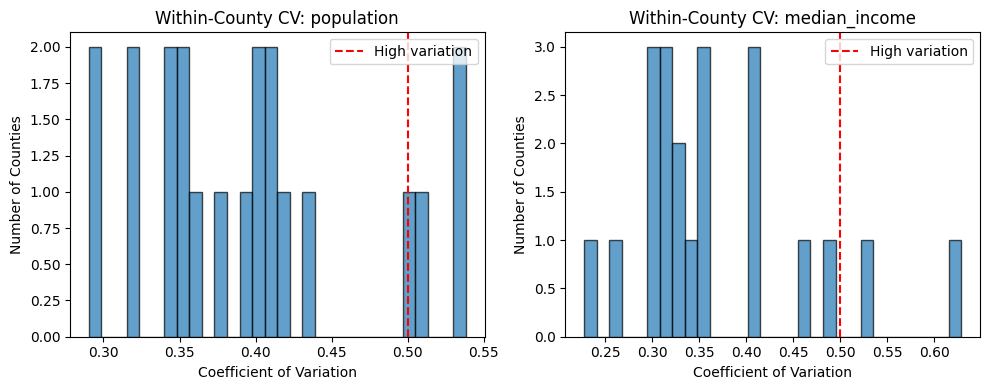

In [60]:
# section 7: data quality analysis
print("\n" + "="*80)
print("section 7: data quality analysis")
print("="*80)

# Missing data summary
print("\nTop 15 columns with missing data:")
missing = merged.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing_pct = (missing / len(merged) * 100).round(1)
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Missing_Percent': missing_pct
})
print(missing_df.head(15).to_string())

# Analyze within-county variation
print("\n" + "="*80)
print("Within-County Variation Analysis")
print("="*80)
print("This shows how much tract-level variables vary WITHIN counties")
print("High variation = county-level FEA data loses important detail")

tract_vars = ['population', 'median_income', 'poverty_rate']
tract_vars = [v for v in tract_vars if v in merged.columns and merged[v].notna().sum() > 0]

for var in tract_vars:
    county_stats = merged.groupby('COUNTYFIPS')[var].agg([
        ('mean', 'mean'),
        ('std', 'std'),
        ('cv', lambda x: x.std() / x.mean() if x.mean() != 0 else 0)
    ])
    
    print(f"\n{var.upper()}:")
    print(f"  Average within-county CV:    {county_stats['cv'].mean():.3f}")
    print(f"  Median within-county CV:     {county_stats['cv'].median():.3f}")
    print(f"  Counties with high var (CV>0.5): {(county_stats['cv'] > 0.5).sum()}")

# Visualize variation
if len(tract_vars) > 0:
    fig, axes = plt.subplots(1, len(tract_vars), figsize=(5*len(tract_vars), 4))
    if len(tract_vars) == 1:
        axes = [axes]
    
    for idx, var in enumerate(tract_vars):
        county_cv = merged.groupby('COUNTYFIPS')[var].apply(
            lambda x: x.std() / x.mean() if x.mean() != 0 else 0
        )
        axes[idx].hist(county_cv.dropna(), bins=30, edgecolor='black', alpha=0.7)
        axes[idx].set_xlabel('Coefficient of Variation')
        axes[idx].set_ylabel('Number of Counties')
        axes[idx].set_title(f'Within-County CV: {var}')
        axes[idx].axvline(0.5, color='red', linestyle='--', label='High variation')
        axes[idx].legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'within_county_variation.png'), dpi=150)
    print(f"\n✓ Saved: {OUTPUT_DIR}/within_county_variation.png")
    plt.show()


In [61]:
# section 8: compute population density

print("\n" + "="*80)
print("section 8: compute population density")
print("="*80)

# Download shapefile if needed
if not os.path.exists(TIGER_SHP):
    print("Downloading NJ tract shapefile from Census Bureau...")
    shp_url = f"https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_{STATE_FIPS}_tract.zip"
    gdf = gpd.read_file(shp_url)
    gdf.to_file(TIGER_SHP)
    print(f"Downloaded and saved to {TIGER_SHP}")
else:
    print(f"Loading shapefile: {TIGER_SHP}")
    gdf = gpd.read_file(TIGER_SHP)

# Construct GEOID in shapefile
if 'GEO_ID' not in gdf.columns:
    gdf['GEO_ID'] = gdf['STATEFP'] + gdf['COUNTYFP'] + gdf['TRACTCE']

# Get land area
gdf = gdf[['GEO_ID', 'ALAND', 'geometry']].copy()

# Convert to metric
gdf['ALAND_km2'] = gdf['ALAND'] / 1e6

# Merge land area to main dataset
merged = merged.merge(gdf[['GEO_ID', 'ALAND_km2']], on='GEO_ID', how='left')

# Compute density
if 'population' in merged.columns:
    merged['density'] = merged['population'] / merged['ALAND_km2']
    merged['density'] = merged['density'].replace([np.inf, -np.inf], np.nan)
    
    print("\nPopulation density statistics:")
    print(merged['density'].describe())
    
    # Categorize urbanicity
    merged['urbanicity'] = pd.cut(
        merged['density'],
        bins=[0, 500, 2000, 5000, np.inf],
        labels=['Rural', 'Suburban', 'Urban', 'Dense_Urban']
    )
    
    print("\nUrbanicity distribution:")
    print(merged['urbanicity'].value_counts())
else:
    print(" Cannot compute density - population column not found")

print("\n Density computed")


section 8: compute population density
Loading shapefile: tl_2020_34_tract.shp

Population density statistics:
count     2175.000000
mean      1353.035199
std       2082.501985
min          0.000000
25%        260.562044
50%        582.018640
75%       1513.866547
max      21348.411851
Name: density, dtype: float64

Urbanicity distribution:
urbanicity
Rural          947
Suburban       801
Urban          299
Dense_Urban    119
Name: count, dtype: int64

 Density computed


In [62]:
# section 9:  features for TDA

print("\n" + "="*80)
print("section 9: preparing features for TDA")
print("="*80)

# Select and standardize socioeconomic features
feature_vars = ['poverty_rate', 'median_income', 'density']
feature_vars = [v for v in feature_vars if v in merged.columns]

print(f"Using {len(feature_vars)} features: {feature_vars}")

# Fill missing values with median
for var in feature_vars:
    median_val = merged[var].median()
    merged[var] = merged[var].fillna(median_val)
    print(f"  {var}: filled {merged[var].isna().sum()} missing values with median {median_val:.2f}")
# Standardize
scaler = StandardScaler()
standardized = scaler.fit_transform(merged[feature_vars])
for idx, var in enumerate(feature_vars):
    merged[f'{var}_s'] = standardized[:, idx]
print("\nStandardized features created (suffix '_s')")

# Compute geographic centroids safely
print("\nComputing tract centroids...")

# Step 1: project to a suitable CRS for area/centroid math
# EPSG:5070 = NAD83 / Conus Albers (good for US-wide work)
gdf_proj = gdf.to_crs(epsg=5070)

# Step 2: compute centroids in projected CRS
gdf_proj['centroid'] = gdf_proj.geometry.centroid

# Step 3: convert centroids back to lat/lon (EPSG:4326)
gdf_cents = gdf_proj.set_geometry('centroid').to_crs(epsg=4326)
gdf_cents['lat'] = gdf_cents.geometry.y
gdf_cents['lon'] = gdf_cents.geometry.x

# Merge centroids back
merged = merged.drop(columns=['lat','lon'], errors='ignore')
merged = merged.merge(
    gdf_cents[['GEO_ID','lat','lon']],
    on='GEO_ID',
    how='left'
)

print(f"Centroids computed for {merged['lat'].notna().sum()} tracts")
print("\nFeatures prepared for TDA")


section 9: preparing features for TDA
Using 2 features: ['median_income', 'density']
  median_income: filled 0 missing values with median 100300.50
  density: filled 0 missing values with median 582.02

Standardized features created (suffix '_s')

Computing tract centroids...
Centroids computed for 2181 tracts

Features prepared for TDA


In [63]:
# section 10: build weighted distance matrix
print("\n" + "="*80)
print("section 10: build weighted distance matrix")
print("="*80)

# Get coordinates and features
coords = merged[['lat', 'lon']].values
#poverty_s = merged['poverty_rate_s'].values
income_s = merged['median_income_s'].values if 'median_income_s' in merged.columns else np.zeros(len(merged))
density_s = merged['density_s'].values if 'density_s' in merged.columns else np.zeros(len(merged))

# Compute geographic distances (Haversine)
print("Computing geographic distances (Haversine)...")
def haversine_matrix(coords_deg):
    lat = np.radians(coords_deg[:, 0])
    lon = np.radians(coords_deg[:, 1])
    dlat = lat[:, None] - lat[None, :]
    dlon = lon[:, None] - lon[None, :]
    a = np.sin(dlat/2)**2 + np.cos(lat)[:, None] * np.cos(lat)[None, :] * np.sin(dlon/2)**2
    return 2 * 6371.0 * np.arcsin(np.sqrt(a))  # Earth radius in km

D_geo = haversine_matrix(coords)
print(f"  Shape: {D_geo.shape}")
print(f"  Mean distance: {D_geo[np.triu_indices_from(D_geo, k=1)].mean():.2f} km")

# Compute socioeconomic distances
print("\nComputing socioeconomic distances...")
#D_pov = squareform(pdist(poverty_s.reshape(-1, 1), metric='cityblock'))
D_inc = squareform(pdist(income_s.reshape(-1, 1), metric='cityblock'))
D_den = squareform(pdist(density_s.reshape(-1, 1), metric='cityblock'))

# Weighted combination
print(f"\nCombining with weights:")
print(f"  Geographic:  1.0")
#print(f"  Poverty:     {alpha_poverty}")
print(f"  Income:      {alpha_income}")
print(f"  Density:     {alpha_density}")

# exclusing alpha_poverty * D_pov 
D_weighted = D_geo + alpha_income * D_inc + alpha_density * D_den

# Set max edge length
MAX_EDGE = np.percentile(D_weighted[np.triu_indices_from(D_weighted, k=1)], 90) # 90 1st try
print(f"\nMAX_EDGE set to 90th percentile: {MAX_EDGE:.2f}")

# Save distance matrix
np.save(os.path.join(OUTPUT_DIR, 'D_weighted.npy'), D_weighted)
print(f" Saved: {OUTPUT_DIR}/D_weighted.npy")

print("\nWeighted distance matrix built")


section 10: build weighted distance matrix
Computing geographic distances (Haversine)...
  Shape: (2181, 2181)
  Mean distance: 73.05 km

Computing socioeconomic distances...

Combining with weights:
  Geographic:  1.0
  Income:      0.1
  Density:     0.1

MAX_EDGE set to 90th percentile: 144.16
 Saved: project_outputs/D_weighted.npy

Weighted distance matrix built


In [64]:
# section 10: rebuild distance matrix with poverty - UPDATED

print("\n" + "="*80)
print("updated section 10: rebuild distance matrix with poverty")
print("="*80)

# Use composite poverty index instead of/in addition to income
if 'poverty_composite_index' in merged.columns:
    alpha_poverty = 0.2
    print(f"Including poverty composite index with weight: {alpha_poverty}")
    
    poverty_composite = merged['poverty_composite_index'].values
    income_s = merged['median_income_s'].values if 'median_income_s' in merged.columns else np.zeros(len(merged))
    density_s = merged['density_s'].values if 'density_s' in merged.columns else np.zeros(len(merged))
    
    # Recompute distances
    print("Computing socioeconomic distances...")
    D_pov = squareform(pdist(poverty_composite.reshape(-1, 1), metric='cityblock'))
    D_inc = squareform(pdist(income_s.reshape(-1, 1), metric='cityblock'))
    D_den = squareform(pdist(density_s.reshape(-1, 1), metric='cityblock'))
    
    print(f"\nCombining with weights:")
    print(f"  Geographic:  1.0")
    print(f"  Poverty:     {alpha_poverty}")
    print(f"  Income:      {alpha_income}")
    print(f"  Density:     {alpha_density}")
    
    # Weighted combination with poverty
    D_weighted = D_geo + alpha_poverty * D_pov + alpha_income * D_inc + alpha_density * D_den
    
    # Update MAX_EDGE
    MAX_EDGE = np.percentile(D_weighted[np.triu_indices_from(D_weighted, k=1)], 85)
    print(f"\nMAX_EDGE updated to 85th percentile: {MAX_EDGE:.2f}")
    
    # Save updated distance matrix
    np.save(os.path.join(OUTPUT_DIR, 'D_weighted_with_poverty.npy'), D_weighted)
    print(f"Saved: {OUTPUT_DIR}/D_weighted_with_poverty.npy")
    
    
    



updated section 10: rebuild distance matrix with poverty
Including poverty composite index with weight: 0.2
Computing socioeconomic distances...

Combining with weights:
  Geographic:  1.0
  Poverty:     0.2
  Income:      0.1
  Density:     0.1

MAX_EDGE updated to 85th percentile: 130.06
Saved: project_outputs/D_weighted_with_poverty.npy


### Enhanced Section 10: KNN Rips Complex


SECTION 10: KNN-Rips with Poverty-Weighted Features
Standardized features:
  Poverty:  mean=0.000, std=1.000
  Income:   mean=-0.000, std=1.000
  Density:  mean=0.000, std=0.000

Computing geographic distances (Haversine)...
D_geo shape: (2181, 2181)
D_geo range: [0.11, 262.43] km

Feature weights:
  Geographic:  0.6
  Poverty:     0.15
  Income:      0.15
  Density:     0.1
  Sum:         1.0

Feature matrix shape: (2181, 5)

PCA: 5 → 5 dimensions
Explained variance: 1.000
Per component: [7.98300497e-01 2.01693558e-01 4.02655371e-06 1.91767384e-06
 0.00000000e+00]

Building KNN graph with K=8...
Neighbors shape: (2181, 8)
Feature distances range: [0.170, 29.374]

Building KNN-filtered distance matrix with geographic distances...
KNN edges created: 10501
KNN distance range: [0.11, 26.12] km

MAX_EDGE (85th percentile of KNN distances): 5.69 km
Graph density: 0.0044 (10501/2377290 edges)

--- Neighborhood Analysis ---

Tract 1817:
  Poverty index: 1.03
  Avg neighbor geo dist: 1.22 km


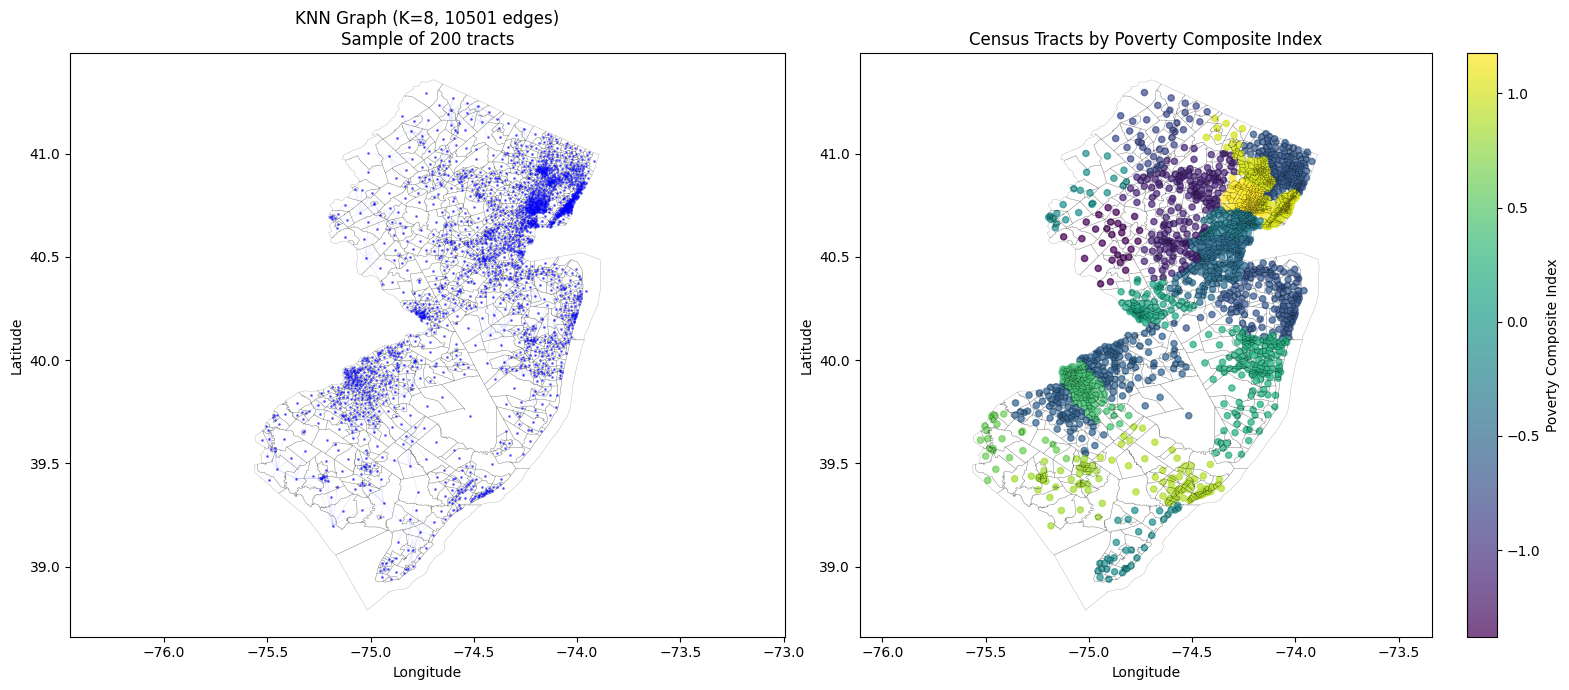


Section 10 Complete: KNN-Rips with poverty features ready


In [65]:
# === SECTION 10: REBUILD DISTANCE MATRIX WITH POVERTY (KNN-RIPS VERSION) ===
print("\n" + "="*80)
print("SECTION 10: KNN-Rips with Poverty-Weighted Features")
print("="*80)

# 1. Extract and normalize all features
poverty_composite = merged['poverty_composite_index'].values if 'poverty_composite_index' in merged.columns else merged['poverty_rate'].values
income_raw = merged['median_income'].values if 'median_income' in merged.columns else np.zeros(len(merged))
density_raw = merged['population_density'].values if 'population_density' in merged.columns else np.zeros(len(merged))

# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

poverty_s = scaler.fit_transform(poverty_composite.reshape(-1, 1)).flatten()
income_s = scaler.fit_transform(income_raw.reshape(-1, 1)).flatten()
density_s = scaler.fit_transform(density_raw.reshape(-1, 1)).flatten()

print(f"Standardized features:")
print(f"  Poverty:  mean={poverty_s.mean():.3f}, std={poverty_s.std():.3f}")
print(f"  Income:   mean={income_s.mean():.3f}, std={income_s.std():.3f}")
print(f"  Density:  mean={density_s.mean():.3f}, std={density_s.std():.3f}")

# 2. Compute geographic distances (Haversine)
print("\nComputing geographic distances (Haversine)...")

def haversine_matrix(coords_deg):
    """Compute pairwise Haversine distances in kilometers"""
    lat = np.radians(coords_deg[:, 0])
    lon = np.radians(coords_deg[:, 1])
    dlat = lat[:, None] - lat[None, :]
    dlon = lon[:, None] - lon[None, :]
    a = np.sin(dlat/2)**2 + np.cos(lat)[:, None] * np.cos(lat)[None, :] * np.sin(dlon/2)**2
    return 2 * 6371.0 * np.arcsin(np.sqrt(a))

D_geo = haversine_matrix(coords)
print(f"D_geo shape: {D_geo.shape}")
print(f"D_geo range: [{D_geo[D_geo > 0].min():.2f}, {D_geo.max():.2f}] km")

# 3. Build composite feature matrix for KNN
# Weight parameters
geo_weight = 0.6        # Geographic proximity
poverty_weight = 0.15   # Poverty similarity
income_weight = 0.15    # Income similarity
density_weight = 0.10   # Density similarity

print(f"\nFeature weights:")
print(f"  Geographic:  {geo_weight}")
print(f"  Poverty:     {poverty_weight}")
print(f"  Income:      {income_weight}")
print(f"  Density:     {density_weight}")
print(f"  Sum:         {geo_weight + poverty_weight + income_weight + density_weight}")

# Normalize coordinates for feature space (approximate km scale)
coords_normalized = coords.copy()
coords_normalized[:, 0] = (coords[:, 0] - coords[:, 0].mean()) / coords[:, 0].std() * 100  # Scale to ~km
coords_normalized[:, 1] = (coords[:, 1] - coords[:, 1].mean()) / coords[:, 1].std() * 100

# Build weighted feature matrix
feat_matrix = np.column_stack([
    coords_normalized * geo_weight,
    poverty_s.reshape(-1, 1) * poverty_weight,
    income_s.reshape(-1, 1) * income_weight,
    density_s.reshape(-1, 1) * density_weight
])

print(f"\nFeature matrix shape: {feat_matrix.shape}")

# 4. Optional: PCA for dimensionality reduction (helps with high-dimensional feature spaces)
use_pca = True
if use_pca and feat_matrix.shape[1] > 4:
    from sklearn.decomposition import PCA
    n_components = min(5, feat_matrix.shape[1])
    pca = PCA(n_components=n_components)
    feat_pca = pca.fit_transform(feat_matrix)
    print(f"\nPCA: {feat_matrix.shape[1]} → {n_components} dimensions")
    print(f"Explained variance: {pca.explained_variance_ratio_.sum():.3f}")
    print(f"Per component: {pca.explained_variance_ratio_}")
    feat_for_knn = feat_pca
else:
    feat_for_knn = feat_matrix

# 5. Build KNN graph in feature space
K = 8  # Number of neighbors
print(f"\nBuilding KNN graph with K={K}...")

from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(n_neighbors=K+1, algorithm='ball_tree', metric='euclidean')
nn.fit(feat_for_knn)

distances_feat, neighbors = nn.kneighbors(feat_for_knn)

# Remove self (first neighbor)
neighbors = neighbors[:, 1:]
distances_feat = distances_feat[:, 1:]

print(f"Neighbors shape: {neighbors.shape}")
print(f"Feature distances range: [{distances_feat.min():.3f}, {distances_feat.max():.3f}]")

# 6. Build sparse distance matrix: KNN topology with GEOGRAPHIC distances
print("\nBuilding KNN-filtered distance matrix with geographic distances...")

D_knn = np.full((len(coords), len(coords)), np.inf)

for i in range(len(coords)):
    for j in neighbors[i]:
        # Use TRUE geographic distance for filtration
        geo_dist = D_geo[i, j]
        D_knn[i, j] = geo_dist
        D_knn[j, i] = geo_dist  # Symmetric

num_edges = np.sum(D_knn < np.inf) // 2
print(f"KNN edges created: {num_edges}")
print(f"KNN distance range: [{D_knn[D_knn < np.inf].min():.2f}, {D_knn[D_knn < np.inf].max():.2f}] km")

# 7. Set MAX_EDGE based on KNN distances
MAX_EDGE = np.percentile(D_knn[D_knn < np.inf], 85)
print(f"\nMAX_EDGE (85th percentile of KNN distances): {MAX_EDGE:.2f} km")

# 8. Diagnostic: Compare KNN vs full graph
density_ratio = num_edges / (len(coords) * (len(coords) - 1) / 2)
print(f"Graph density: {density_ratio:.4f} ({num_edges}/{len(coords)*(len(coords)-1)//2} edges)")

# 9. Analyze feature-based neighborhoods
print("\n--- Neighborhood Analysis ---")
sample_indices = np.random.choice(len(coords), min(5, len(coords)), replace=False)

for idx in sample_indices:
    nbr_idx = neighbors[idx]
    
    # Compare feature similarity vs geographic distance
    feat_dists = distances_feat[idx]
    geo_dists = D_geo[idx, nbr_idx]
    
    poverty_diff = np.abs(poverty_s[idx] - poverty_s[nbr_idx])
    
    print(f"\nTract {idx}:")
    print(f"  Poverty index: {poverty_composite[idx]:.2f}")
    print(f"  Avg neighbor geo dist: {geo_dists.mean():.2f} km")
    print(f"  Avg neighbor poverty diff: {poverty_diff.mean():.2f}")
    print(f"  Feature space dist range: [{feat_dists.min():.3f}, {feat_dists.max():.3f}]")

# 10. Save results
print("\n--- Saving Results ---")
np.save(os.path.join(OUTPUT_DIR, 'D_knn_poverty_weighted.npy'), D_knn)
np.save(os.path.join(OUTPUT_DIR, 'knn_neighbors.npy'), neighbors)
np.save(os.path.join(OUTPUT_DIR, 'feature_matrix.npy'), feat_matrix)

# Save metadata
metadata = {
    'K': K,
    'MAX_EDGE': float(MAX_EDGE),
    'num_edges': int(num_edges),
    'weights': {
        'geographic': geo_weight,
        'poverty': poverty_weight,
        'income': income_weight,
        'density': density_weight
    },
    'use_pca': use_pca,
    'pca_variance': float(pca.explained_variance_ratio_.sum()) if use_pca else None
}

import json
with open(os.path.join(OUTPUT_DIR, 'knn_metadata.json'), 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✓ Saved: {OUTPUT_DIR}/D_knn_poverty_weighted.npy")
print(f"✓ Saved: {OUTPUT_DIR}/knn_neighbors.npy")
print(f"✓ Saved: {OUTPUT_DIR}/feature_matrix.npy")
print(f"✓ Saved: {OUTPUT_DIR}/knn_metadata.json")

# 11. Visualization: KNN graph structure
print("\n--- Visualizing KNN Graph ---")

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Geographic KNN edges
ax = axes[0]
if 'geometry' in gdf.columns:
    gdf.boundary.plot(ax=ax, linewidth=0.3, edgecolor='black', alpha=0.3)

# Sample edges for visualization (too many to plot all)
sample_tracts = np.random.choice(len(coords), min(200, len(coords)), replace=False)
for i in sample_tracts:
    for j in neighbors[i]:
        ax.plot([coords[i, 1], coords[j, 1]], 
            [coords[i, 0], coords[j, 0]], 
            'b-', alpha=0.1, linewidth=0.5)

ax.scatter(coords[:, 1], coords[:, 0], c='blue', s=1, alpha=0.5, zorder=3)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'KNN Graph (K={K}, {num_edges} edges)\nSample of 200 tracts')
ax.set_aspect('equal', adjustable='datalim')

# Plot 2: Poverty coloring
ax = axes[1]
if 'geometry' in gdf.columns:
    gdf.boundary.plot(ax=ax, linewidth=0.3, edgecolor='black', alpha=0.3)
scatter = ax.scatter(coords[:, 1], coords[:, 0], 
                    c=poverty_composite, cmap='viridis', 
                    s=20, alpha=0.7)
plt.colorbar(scatter, ax=ax, label='Poverty Composite Index')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Census Tracts by Poverty Composite Index')
ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'knn_graph_poverty.png'), dpi=150, bbox_inches='tight')
print(f"✓ Saved: {OUTPUT_DIR}/knn_graph_poverty.png")
plt.show()

print("\n" + "="*80)
print("Section 10 Complete: KNN-Rips with poverty features ready")
print("="*80)



section 11: computing persistent homology
Building Vietoris-Rips complex...
  Simplices: 720,127
  Vertices: 2,181

Computing persistence...
✓ Persistence computed in 1.46s

Persistence pairs:
  H0 (connected components): 2181
  H1 (loops/holes):          689
Saved: project_outputs/persistence_diagram.png


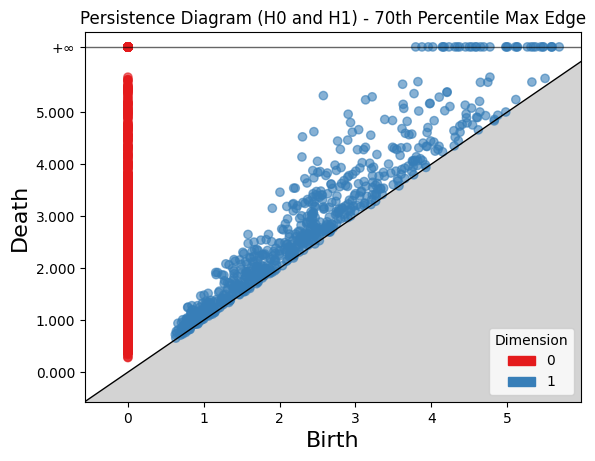

In [ ]:
#section 11: computing persistent homology

"""
Since we are working with such a densely populated area, we need to adjust the max edge length to capture more local features
We may also need to normalize the data so that larger outliers do not skew the distance matrix too much and we can better capture the most persistent holes in the data. 
"""

if USE_GUDHI:
    print("\n" + "="*80)
    print("section 11: computing persistent homology")
    print("="*80)
    
    print("Building Vietoris-Rips complex...")
    start_time = time.time()
    
    rips = gd.RipsComplex(distance_matrix=D_weighted, max_edge_length=MAX_EDGE)
    st = rips.create_simplex_tree(max_dimension=MAX_DIM)
    
    print(f"  Simplices: {st.num_simplices():,}")
    print(f"  Vertices: {st.num_vertices():,}")
    
    print("\nComputing persistence...")
    pers = st.persistence()
    elapsed = time.time() - start_time
    print(f"Persistence computed in {elapsed:.2f}s")
    
    # Extract diagrams
    h0 = [(b, d if d != float('inf') else MAX_EDGE*1.1) for dim, (b, d) in pers if dim == 0]
    h1 = [(b, d if d != float('inf') else MAX_EDGE*1.1) for dim, (b, d) in pers if dim == 1]
    
    print(f"\nPersistence pairs:")
    print(f"  H0 (connected components): {len(h0)}")
    print(f"  H1 (loops/holes):          {len(h1)}")
    
    # Plot persistence diagram
    gd.plot_persistence_diagram(pers)
    plt.title('Persistence Diagram (H0 and H1) - 70th Percentile Max Edge')
    plt.savefig(os.path.join(OUTPUT_DIR, 'persistence_diagram_70.png'), dpi=150)
    print(f"Saved: {OUTPUT_DIR}/persistence_diagram.png")
    plt.show()

SECTION 11 — Computing kNN-filtered Vietoris Rips persistence
Using max Rips radius: 105.37 km
  Number of simplices: 29105


<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

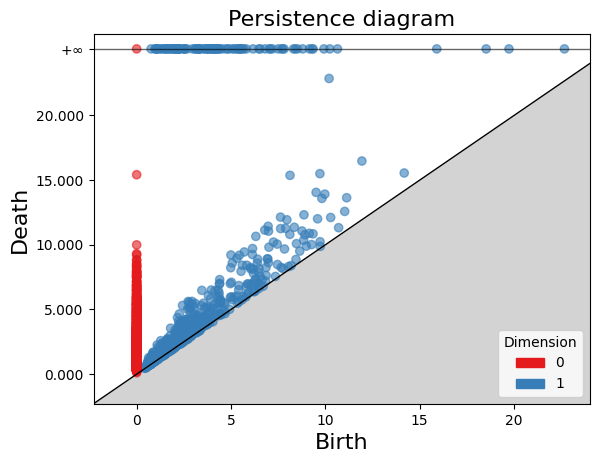

In [67]:
# UODATED SECTION 11: 
print("SECTION 11 — Computing kNN-filtered Vietoris Rips persistence")

# 1. Choose meaningful max radius (e.g., 75th percentile)
max_r = np.percentile(D_geo[D_geo < np.inf], 75)
print(f"Using max Rips radius: {max_r:.2f} km")

# 2. Build kNN-Rips
rips = gd.RipsComplex(distance_matrix=D_knn, max_edge_length=max_r)
st = rips.create_simplex_tree(max_dimension=2)

print("  Number of simplices:", st.num_simplices())

# 3. Compute persistence
diag = st.persistence(homology_coeff_field=2)

# 4. Plot PD
gd.plot_persistence_diagram(diag)



Extracting death simplices...
H0 death simplices found: 8
H1 death simplices found: 0

 Saved: project_outputs/death_simplices_map.png


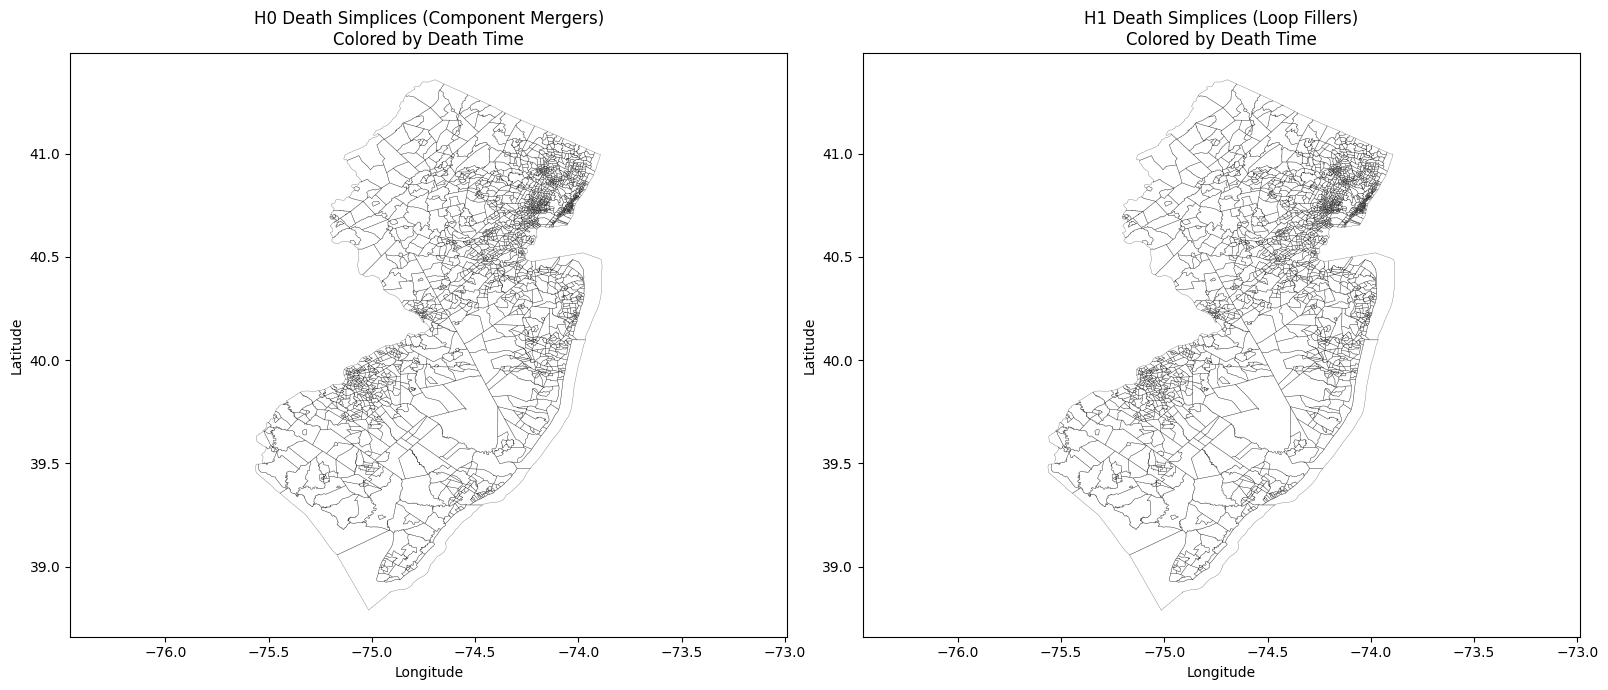


Creating barcode plots...
✓ Saved: project_outputs/persistence_barcodes.png


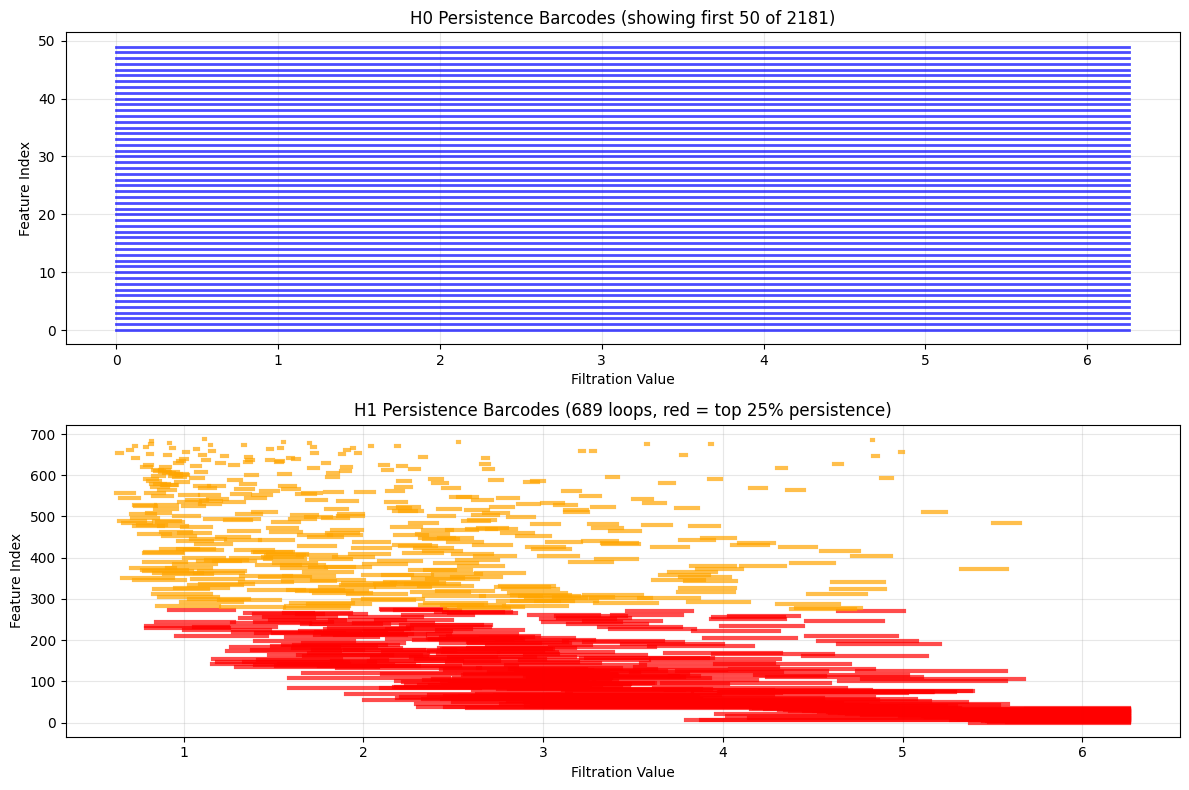

In [68]:
if USE_GUDHI:
    # Extract death simplices
    def get_death_simplices(simplex_tree, persistence_pairs, dimension):
        """Extract simplices that kill features in given dimension"""
        death_simplices = []
        death_times = []
        
        for item in persistence_pairs:
            # GUDHI returns tuples like (dimension, (birth, death))
            if len(item) == 2:
                dim, pair = item
                birth, death = pair
            else:
                continue
                
            if dim != dimension or death == float('inf'):
                continue
            if dim != dimension or death == float('inf'):
                continue
                
            # Find the simplex that exists at death time
            for simplex, filt in simplex_tree.get_filtration():
                if abs(filt - death) < 1e-6 and len(simplex) == dim + 2:
                    death_simplices.append(simplex)
                    death_times.append((birth, death))
                    break
        
        return death_simplices, death_times
    
    
    # Get death simplices for H0 and H1
    print("\nExtracting death simplices...")
    #print(pers)
    death_simplices_h0, death_times_h0 = get_death_simplices(st, pers, dimension=0)
    death_simplices_h1, death_times_h1 = get_death_simplices(st, pers, dimension=1)
    
    print(f"H0 death simplices found: {len(death_simplices_h0)}")
    print(f"H1 death simplices found: {len(death_simplices_h1)}")
    
    # Visualize death simplices in geographic space (styled like the paper)
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    from matplotlib.colors import Normalize
    from matplotlib.cm import ScalarMappable
    
    # H0 death simplices (edges that merge components)
    ax = axes[0]
    
    # Draw tract boundaries if shapefile available
    if 'geometry' in gdf.columns:
        gdf.boundary.plot(ax=ax, linewidth=0.3, edgecolor='black', alpha=0.5)
    
    # Plot all H0 death simplices with color gradient based on death time
    if len(death_simplices_h0) > 0: 
        death_values_h0 = [d for b, d in death_times_h0 if d > 6.0]
        
        if len(death_values_h0) > 0:
            norm = Normalize(vmin=4, vmax=max(death_values_h0))
            cmap = plt.cm.viridis  # Similar to the paper's color scheme
            
            for (b, d), simplex in zip(death_times_h0, death_simplices_h0):
                if len(simplex) == 2:  # Edge
                    pt1, pt2 = simplex
                    color = cmap(norm(d))
                    ax.plot([coords[pt1, 1], coords[pt2, 1]], 
                        [coords[pt1, 0], coords[pt2, 0]], 
                        color=color, alpha=0.8, linewidth=2)
            
            # Add colorbar
            sm = ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
            cbar.set_label('Death Time (Filtration Value)', rotation=270, labelpad=20)
            
            print(f"\nH0 death simplices plotted: {len(death_simplices_h0)}")
            # Sort by persistence and show top 5
            persistence_h0 = [(d - b, b, d, simplex) for (b, d), simplex in zip(death_times_h0, death_simplices_h0)]
            persistence_h0.sort(reverse=True)
            print(f"Top 5 H0 death simplices (most persistent):")
            for i, (pers, b, d, simplex) in enumerate(persistence_h0[:5]):
                print(f"  {i+1}. Persistence: {pers:.4f}, Death: {d:.4f}, Edge: {simplex}")
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('H0 Death Simplices (Component Mergers)\nColored by Death Time')
    ax.set_aspect('equal', adjustable='datalim')
    
    # H1 death simplices (triangles that fill loops)
    ax = axes[1]
    
    # Draw tract boundaries
    if 'geometry' in gdf.columns:
        gdf.boundary.plot(ax=ax, linewidth=0.3, edgecolor='black', alpha=0.5)
    
    # Plot all H1 death simplices with color gradient based on death time
    if len(death_simplices_h1) > 0:
        death_values_h1 = [d for b, d in death_times_h1]
        
        if len(death_values_h1) > 0:
            norm = Normalize(vmin=4, vmax=max(death_values_h1))
            cmap = plt.cm.viridis
            
            for (b, d), simplex in zip(death_times_h1, death_simplices_h1):
                if len(simplex) == 3:  # Triangle
                    pts = list(simplex)
                    color = cmap(norm(d))
                    triangle = plt.Polygon(coords[pts][:, [1, 0]], 
                                        fill=True, alpha=0.7, facecolor=color, 
                                        edgecolor='none')
                    ax.add_patch(triangle)
            
            # Add colorbar
            sm = ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
            cbar.set_label('Death Time (Filtration Value)', rotation=270, labelpad=20)
            
            print(f"\nH1 death simplices plotted: {len(death_simplices_h1)}")
            # Sort by persistence and show top 5
            persistence_h1 = [(d - b, b, d, simplex) for (b, d), simplex in zip(death_times_h1, death_simplices_h1)]
            persistence_h1.sort(reverse=True)
            print(f"Top 5 H1 death simplices (most persistent loops):")
            for i, (pers, b, d, simplex) in enumerate(persistence_h1[:5]):
                print(f"  {i+1}. Persistence: {pers:.4f}, Death: {d:.4f}, Triangle: {simplex}")
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('H1 Death Simplices (Loop Fillers)\nColored by Death Time')
    ax.set_aspect('equal', adjustable='datalim')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'death_simplices_map.png'), dpi=150, bbox_inches='tight')
    print(f"\n Saved: {OUTPUT_DIR}/death_simplices_map.png")
    plt.show()
    
    # Create barcode plot
    print("\nCreating barcode plots...")
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # H0 barcodes
    ax = axes[0]
    for i, (birth, death) in enumerate(h0[:50]):  # Plot first 50
        ax.plot([birth, death], [i, i], 'b-', linewidth=2, alpha=0.7)
    ax.set_xlabel('Filtration Value')
    ax.set_ylabel('Feature Index')
    ax.set_title(f'H0 Persistence Barcodes (showing first 50 of {len(h0)})')
    ax.grid(True, alpha=0.3)
    
    # H1 barcodes
    ax = axes[1]
    if len(h1) > 0:
        for i, (birth, death) in enumerate(h1):
            color = 'red' if (death - birth) > np.percentile([d-b for b,d in h1], 60) else 'orange'
            ax.plot([birth, death], [i, i], color=color, linewidth=3, alpha=0.7)
    ax.set_xlabel('Filtration Value')
    ax.set_ylabel('Feature Index')
    ax.set_title(f'H1 Persistence Barcodes ({len(h1)} loops, red = top 25% persistence)')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'persistence_barcodes.png'), dpi=150, bbox_inches='tight')
    print(f"✓ Saved: {OUTPUT_DIR}/persistence_barcodes.png")
    plt.show()


SECTION 11: Scalable Persistent Homology (Focus on Persistent Features)
Building KNN-Rips complex...
This approach scales to larger datasets and focuses on persistent features
  Simplices: 23,960
  Vertices: 2,181

Computing persistence...
✓ Persistence computed in 0.41s

Persistence pairs:
  H0 (connected components): 2181
  H1 (loops/holes):          720

H0 persistence statistics:
  Mean: 1.8017
  Median: 1.4088
  Max: 6.2607
  75th percentile: 2.2236

H1 persistence statistics:
  Mean: 0.7680
  Median: 0.3443
  Max: 5.4937
  75th percentile: 0.9051

✓ Saved: project_outputs/persistence_diagram.png


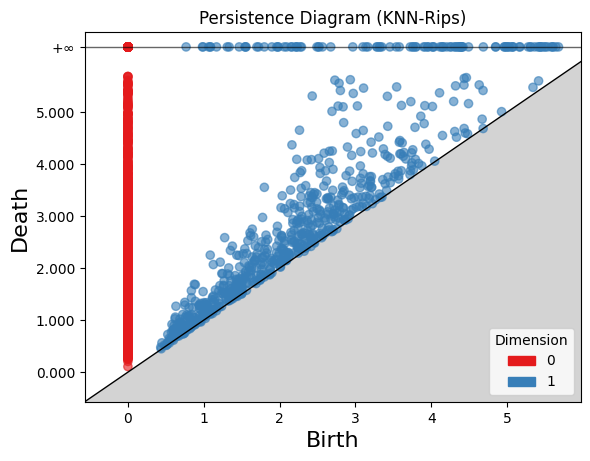


--- Extracting Death Simplices ---
H0 death simplices extracted: 2112
H1 death simplices extracted: 613

--- Filtering to Most Persistent Features ---
H0: Keeping 634 of 2112 features (threshold: 1.9614)

Top 10 H0 features:
  1. Persistence: 5.6857, Death: 5.6857
  2. Persistence: 5.6842, Death: 5.6842
  3. Persistence: 5.6803, Death: 5.6803
  4. Persistence: 5.6103, Death: 5.6103
  5. Persistence: 5.5772, Death: 5.5772
  6. Persistence: 5.5630, Death: 5.5630
  7. Persistence: 5.5513, Death: 5.5513
  8. Persistence: 5.5399, Death: 5.5399
  9. Persistence: 5.5388, Death: 5.5388
  10. Persistence: 5.5299, Death: 5.5299

H1: Keeping 123 of 613 features (threshold: 0.7115)

Top 10 H1 features:
  1. Persistence: 2.8871, Death: 5.6152
  2. Persistence: 2.8801, Death: 5.3099
  3. Persistence: 2.7712, Death: 5.5552
  4. Persistence: 2.6910, Death: 5.6230
  5. Persistence: 2.6153, Death: 5.4162
  6. Persistence: 2.3906, Death: 4.6527
  7. Persistence: 2.3886, Death: 5.3595
  8. Persistence: 2

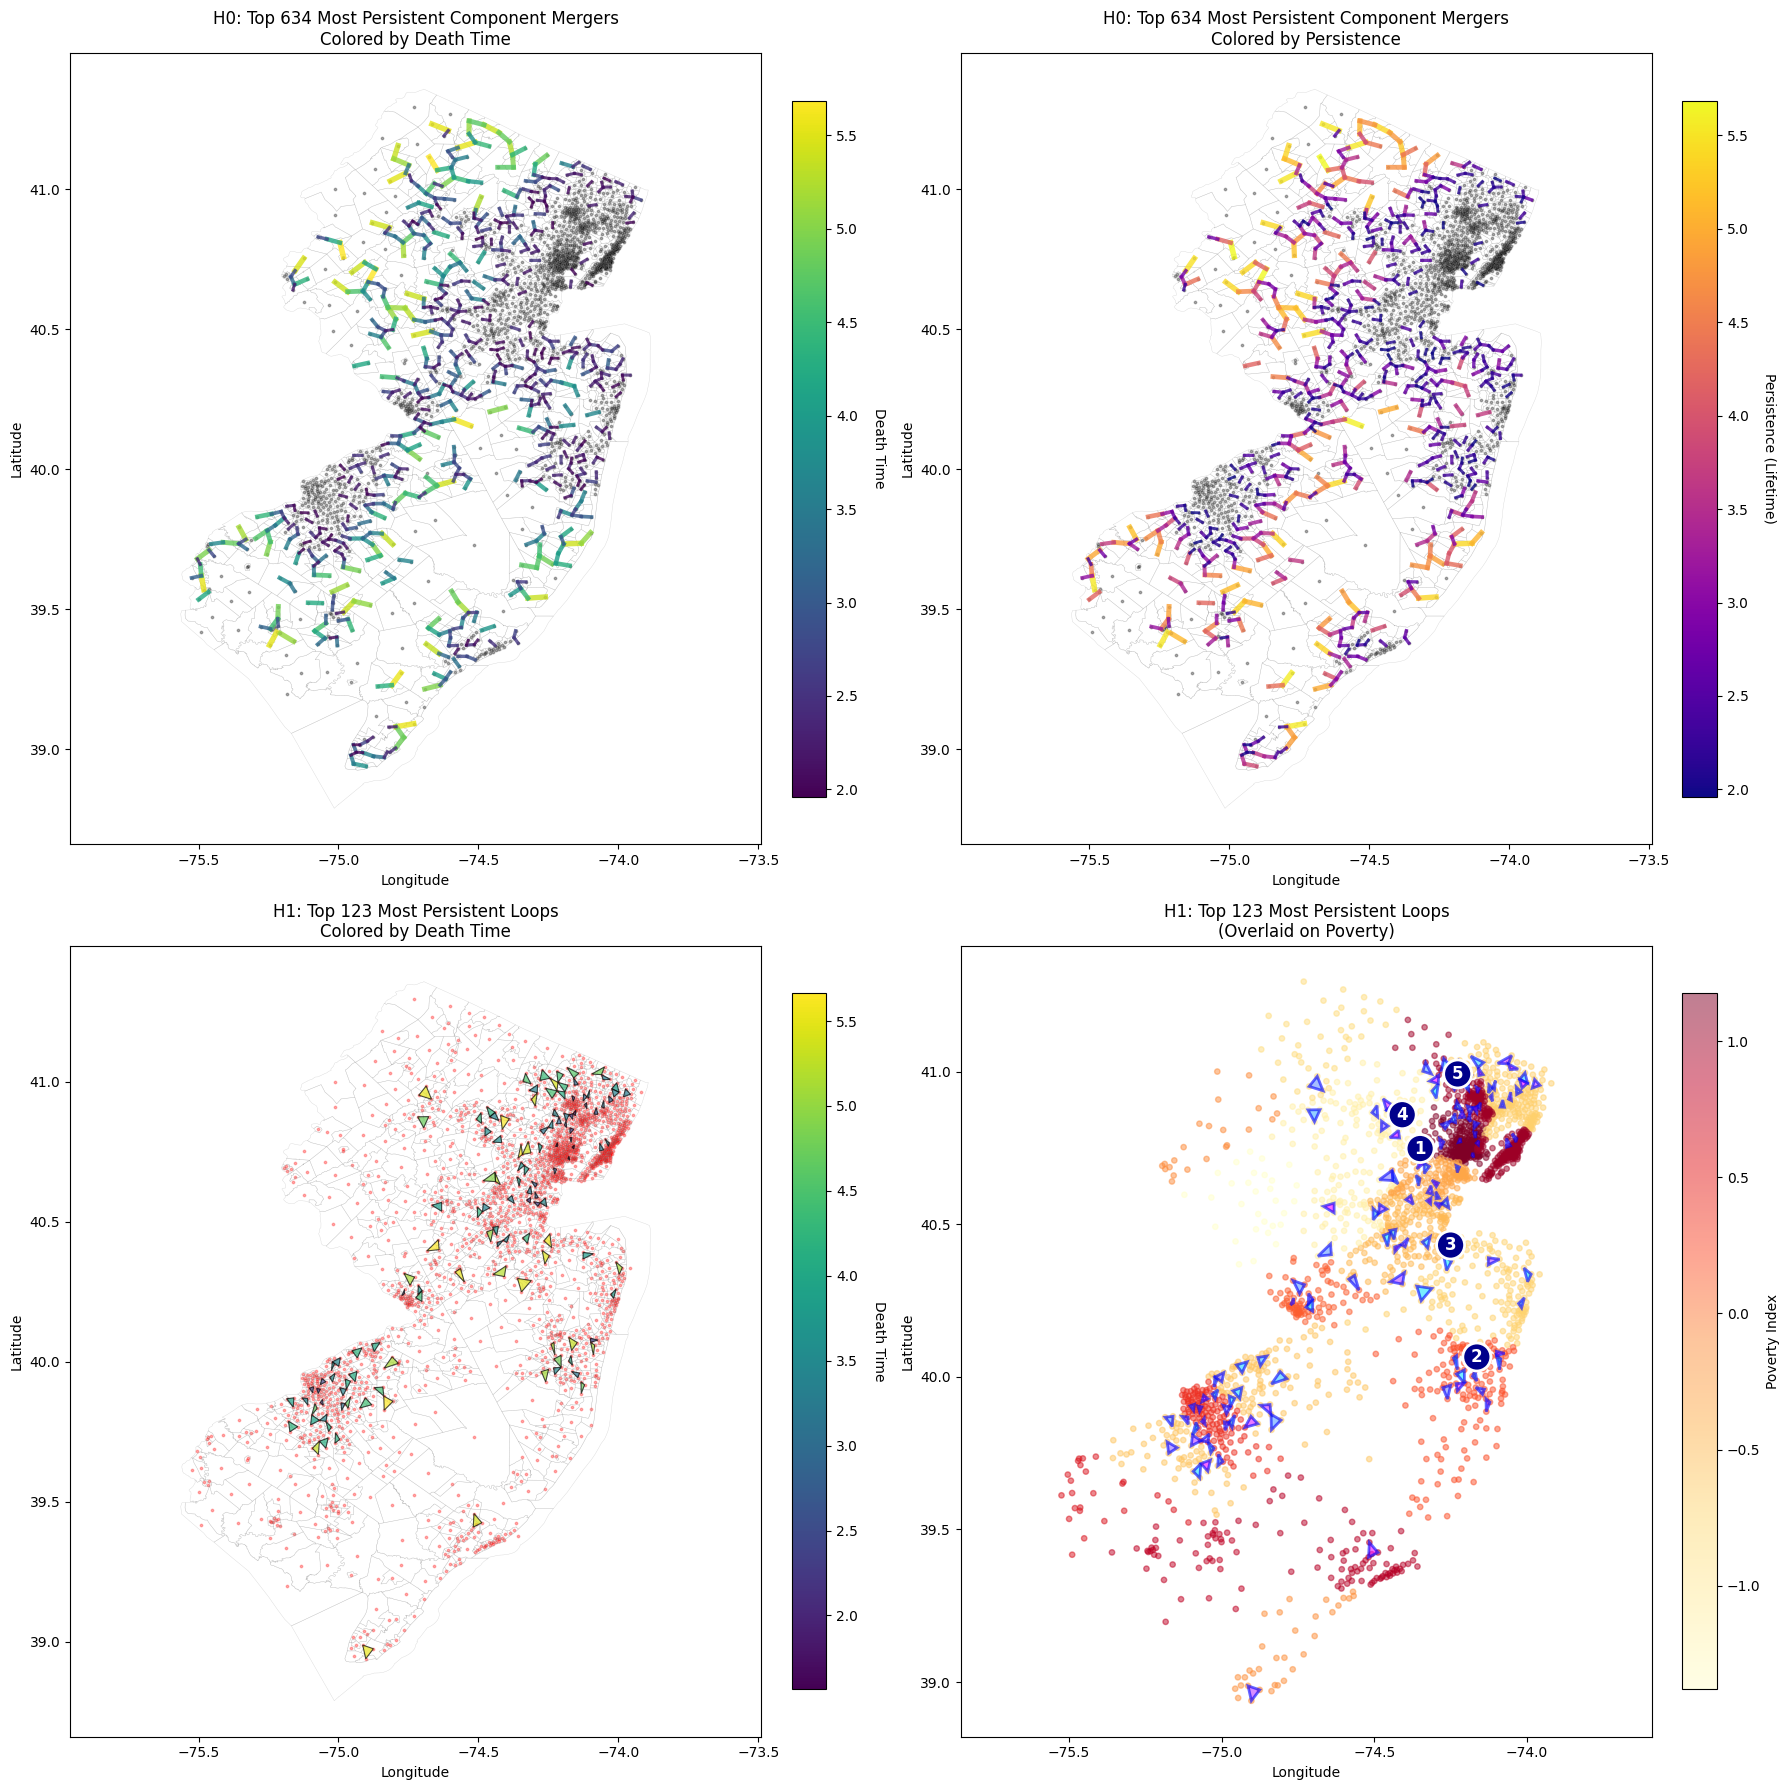


--- Saving Persistent Features ---
✓ Saved: project_outputs/h0_persistent_features.csv
✓ Saved: project_outputs/h1_persistent_features.csv

=== SUMMARY ===
Total H0 features: 2112
Persistent H0 features (top 30%): 634
Total H1 features: 613
Persistent H1 features (top 20%): 123

H1 Poverty Correlation:
  Correlation (persistence vs mean_poverty): -0.101
  Correlation (persistence vs std_poverty): 0.172

Scalable Persistent Homology Complete


In [ ]:
# SECTION 11 FINAL: SCALABLE PERSISTENT HOMOLOGY 
print("\n" + "="*80)
print("SECTION 11: Scalable Persistent Homology (Focus on Persistent Features)")
print("="*80)

if USE_GUDHI:
    print("Building KNN-Rips complex...")
    
    start_time = time.time()
    
    # Use KNN distance matrix (already computed in Section 10)
    rips = gd.RipsComplex(distance_matrix=D_knn, max_edge_length=MAX_EDGE)
    st = rips.create_simplex_tree(max_dimension=2)
    
    print(f"  Simplices: {st.num_simplices():,}")
    print(f"  Vertices: {st.num_vertices():,}")
    
    print("\nComputing persistence...")
    pers = st.persistence()
    elapsed = time.time() - start_time
    print(f"✓ Persistence computed in {elapsed:.2f}s")
    
    # Extract diagrams
    h0 = [(b, d if d != float('inf') else MAX_EDGE*1.1) for dim, (b, d) in pers if dim == 0]
    h1 = [(b, d if d != float('inf') else MAX_EDGE*1.1) for dim, (b, d) in pers if dim == 1]
    
    print(f"\nPersistence pairs:")
    print(f"  H0 (connected components): {len(h0)}")
    print(f"  H1 (loops/holes):          {len(h1)}")
    
    # Calculate persistence statistics
    if len(h0) > 0:
        h0_lifetimes = [d - b for b, d in h0]
        print(f"\nH0 persistence statistics:")
        print(f"  Mean: {np.mean(h0_lifetimes):.4f}")
        print(f"  Median: {np.median(h0_lifetimes):.4f}")
        print(f"  Max: {np.max(h0_lifetimes):.4f}")
        print(f"  75th percentile: {np.percentile(h0_lifetimes, 75):.4f}")
    
    if len(h1) > 0:
        h1_lifetimes = [d - b for b, d in h1]
        print(f"\nH1 persistence statistics:")
        print(f"  Mean: {np.mean(h1_lifetimes):.4f}")
        print(f"  Median: {np.median(h1_lifetimes):.4f}")
        print(f"  Max: {np.max(h1_lifetimes):.4f}")
        print(f"  75th percentile: {np.percentile(h1_lifetimes, 75):.4f}")
    
    # Plot persistence diagram
    gd.plot_persistence_diagram(pers)
    plt.title('Persistence Diagram (KNN-Rips)')
    plt.savefig(os.path.join(OUTPUT_DIR, 'persistence_diagram.png'), dpi=150)
    print(f"\n✓ Saved: {OUTPUT_DIR}/persistence_diagram.png")
    plt.show()
    
    # === EXTRACT DEATH SIMPLICES (ALL) ===
    print("\n--- Extracting Death Simplices ---")
    
    def get_death_simplices(simplex_tree, persistence_pairs, dimension):
        """Extract simplices that kill features in given dimension"""
        death_simplices = []
        death_times = []
        birth_times = []
        
        for item in persistence_pairs:
            if len(item) == 2:
                dim, pair = item
                birth, death = pair
            else:
                continue
                
            if dim != dimension or death == float('inf'):
                continue
                
            # Find the simplex that exists at death time
            for simplex, filt in simplex_tree.get_filtration():
                if abs(filt - death) < 1e-6 and len(simplex) == dim + 2:
                    death_simplices.append(simplex)
                    death_times.append(death)
                    birth_times.append(birth)
                    break
        
        return death_simplices, birth_times, death_times
    
    death_simplices_h0, birth_h0, death_h0 = get_death_simplices(st, pers, dimension=0)
    death_simplices_h1, birth_h1, death_h1 = get_death_simplices(st, pers, dimension=1)
    
    print(f"H0 death simplices extracted: {len(death_simplices_h0)}")
    print(f"H1 death simplices extracted: {len(death_simplices_h1)}")
    
    # === FILTER TO MOST PERSISTENT FEATURES ===
    print("\n--- Filtering to Most Persistent Features ---")
    
    # H0: Keep top features by persistence
    if len(death_simplices_h0) > 0:
        h0_data = [(d - b, b, d, simplex) 
                for b, d, simplex in zip(birth_h0, death_h0, death_simplices_h0)]
        h0_data.sort(reverse=True)
        
        # Determine threshold: top 30% OR features above 75th percentile
        h0_lifetimes = [pers for pers, _, _, _ in h0_data]
        threshold_h0 = np.percentile(h0_lifetimes, 70)  # Top 30%
        
        h0_filtered = [item for item in h0_data if item[0] >= threshold_h0]
        print(f"H0: Keeping {len(h0_filtered)} of {len(h0_data)} features (threshold: {threshold_h0:.4f})")
        
        # Print top 10
        print(f"\nTop 10 H0 features:")
        for i, (pers, b, d, simplex) in enumerate(h0_filtered[:10]):
            print(f"  {i+1}. Persistence: {pers:.4f}, Death: {d:.4f}")
    else:
        h0_filtered = []
    
    # H1: Keep top features by persistence
    if len(death_simplices_h1) > 0:
        h1_data = [(d - b, b, d, simplex) 
                for b, d, simplex in zip(birth_h1, death_h1, death_simplices_h1)]
        h1_data.sort(reverse=True)
        
        # More aggressive filtering for H1: top 20% OR features above 80th percentile
        h1_lifetimes = [pers for pers, _, _, _ in h1_data]
        threshold_h1 = np.percentile(h1_lifetimes, 80)  # Top 20%
        
        h1_filtered = [item for item in h1_data if item[0] >= threshold_h1]
        print(f"\nH1: Keeping {len(h1_filtered)} of {len(h1_data)} features (threshold: {threshold_h1:.4f})")
        
        # Print top 10
        print(f"\nTop 10 H1 features:")
        for i, (pers, b, d, simplex) in enumerate(h1_filtered[:10]):
            print(f"  {i+1}. Persistence: {pers:.4f}, Death: {d:.4f}")
    else:
        h1_filtered = []
    
    # === VISUALIZATION: MOST PERSISTENT FEATURES ONLY ===
    print("\n--- Creating Filtered Visualizations ---")
    
    from matplotlib.colors import Normalize
    from matplotlib.cm import ScalarMappable
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 18))
    
    # PLOT 1: H0 Most Persistent (by death time)
    
    ax = axes[0, 0]
    
    if 'geometry' in gdf.columns:
        gdf.boundary.plot(ax=ax, linewidth=0.3, edgecolor='gray', alpha=0.3)
    
    if len(h0_filtered) > 0:
        death_values = [d for _, _, d, _ in h0_filtered]
        norm = Normalize(vmin=min(death_values), vmax=max(death_values))
        cmap = plt.cm.viridis
        
        for pers, b, d, simplex in h0_filtered:
            if len(simplex) == 2:
                pt1, pt2 = simplex
                color = cmap(norm(d))
                # Line width scales with persistence
                linewidth = 1 + 3 * (pers / h0_filtered[0][0])
                ax.plot([coords[pt1, 1], coords[pt2, 1]], 
                    [coords[pt1, 0], coords[pt2, 0]], 
                    color=color, alpha=0.8, linewidth=linewidth, zorder=2)
        
        sm = ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Death Time', rotation=270, labelpad=20)
    
    ax.scatter(coords[:, 1], coords[:, 0], c='black', s=3, alpha=0.3, zorder=1)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'H0: Top {len(h0_filtered)} Most Persistent Component Mergers\nColored by Death Time')
    ax.set_aspect('equal', adjustable='datalim')
    
    
    # PLOT 2: H0 Most Persistent (by persistence)
    ax = axes[0, 1]
    
    if 'geometry' in gdf.columns:
        gdf.boundary.plot(ax=ax, linewidth=0.3, edgecolor='gray', alpha=0.3)
    
    if len(h0_filtered) > 0:
        pers_values = [pers for pers, _, _, _ in h0_filtered]
        norm = Normalize(vmin=min(pers_values), vmax=max(pers_values))
        cmap = plt.cm.plasma
        
        for pers, b, d, simplex in h0_filtered:
            if len(simplex) == 2:
                pt1, pt2 = simplex
                color = cmap(norm(pers))
                linewidth = 1 + 3 * (pers / h0_filtered[0][0])
                ax.plot([coords[pt1, 1], coords[pt2, 1]], 
                    [coords[pt1, 0], coords[pt2, 0]], 
                    color=color, alpha=0.8, linewidth=linewidth, zorder=2)
        
        sm = ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Persistence (Lifetime)', rotation=270, labelpad=20)
    
    ax.scatter(coords[:, 1], coords[:, 0], c='black', s=3, alpha=0.3, zorder=1)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'H0: Top {len(h0_filtered)} Most Persistent Component Mergers\nColored by Persistence')
    ax.set_aspect('equal', adjustable='datalim')

    # PLOT 3: H1 Most Persistent (by death time)
    ax = axes[1, 0]
    
    if 'geometry' in gdf.columns:
        gdf.boundary.plot(ax=ax, linewidth=0.3, edgecolor='gray', alpha=0.3)
    
    if len(h1_filtered) > 0:
        death_values = [d for _, _, d, _ in h1_filtered]
        norm = Normalize(vmin=min(death_values), vmax=max(death_values))
        cmap = plt.cm.viridis
        
        for pers, b, d, simplex in h1_filtered:
            if len(simplex) == 3:
                pts = list(simplex)
                color = cmap(norm(d))
                triangle = plt.Polygon(coords[pts][:, [1, 0]], 
                                    fill=True, alpha=0.7, facecolor=color, 
                                    edgecolor='black', linewidth=0.8, zorder=2)
                ax.add_patch(triangle)
        
        sm = ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Death Time', rotation=270, labelpad=20)
    
    ax.scatter(coords[:, 1], coords[:, 0], c='red', s=3, alpha=0.3, zorder=1)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'H1: Top {len(h1_filtered)} Most Persistent Loops\nColored by Death Time')
    ax.set_aspect('equal', adjustable='datalim')

    # PLOT 4: H1 Most Persistent on Poverty Map
    ax = axes[1, 1]
    
    # Poverty background
    if 'poverty_composite_index' in merged.columns:
        scatter = ax.scatter(coords[:, 1], coords[:, 0], 
                        c=merged['poverty_composite_index'].values,
                        cmap='viridis', s=15, alpha=0.5, zorder=1)
        plt.colorbar(scatter, ax=ax, label='Poverty Index', fraction=0.046, pad=0.04)
    
    # Overlay top loops
    if len(h1_filtered) > 0:
        colors = plt.cm.cool(np.linspace(0, 1, len(h1_filtered)))
        
        for idx, (pers, b, d, simplex) in enumerate(h1_filtered):
            if len(simplex) == 3:
                pts = list(simplex)
                triangle = plt.Polygon(coords[pts][:, [1, 0]], 
                                    fill=True, alpha=0.6, facecolor=colors[idx], 
                                    edgecolor='blue', linewidth=2, zorder=2)
                ax.add_patch(triangle)
                
                # Label top 5
                if idx < 5:
                    centroid = coords[pts].mean(axis=0)
                    ax.text(centroid[1], centroid[0], str(idx+1),
                        fontsize=12, fontweight='bold',
                        color='white', ha='center', va='center',
                        bbox=dict(boxstyle='circle', facecolor='darkblue', 
                                edgecolor='white', linewidth=2),
                        zorder=4)
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'H1: Top {len(h1_filtered)} Most Persistent Loops\n(Overlaid on Poverty)')
    ax.set_aspect('equal', adjustable='datalim')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'persistent_features_filtered.png'), 
            dpi=200, bbox_inches='tight')
    print(f"\n✓ Saved: {OUTPUT_DIR}/persistent_features_filtered.png")
    plt.show()
    
    # SAVE PERSISTENT FEATURES FOR ANALYSIS 
    print("\n--- Saving Persistent Features ---")
    
    # Save H0 features
    h0_df = pd.DataFrame([
        {
            'persistence': pers,
            'birth': b,
            'death': d,
            'vertex1': simplex[0] if len(simplex) == 2 else None,
            'vertex2': simplex[1] if len(simplex) == 2 else None,
        }
        for pers, b, d, simplex in h0_filtered
    ])
    h0_df.to_csv(os.path.join(OUTPUT_DIR, 'h0_persistent_features.csv'), index=False)
    print(f"✓ Saved: {OUTPUT_DIR}/h0_persistent_features.csv")
    
    # Save H1 features with poverty stats
    h1_records = []
    for pers, b, d, simplex in h1_filtered:
        if len(simplex) == 3:
            pts = list(simplex)
            poverty_vals = merged['poverty_composite_index'].values[pts]
            
            h1_records.append({
                'persistence': pers,
                'birth': b,
                'death': d,
                'vertex1': pts[0],
                'vertex2': pts[1],
                'vertex3': pts[2],
                'mean_poverty': poverty_vals.mean(),
                'max_poverty': poverty_vals.max(),
                'min_poverty': poverty_vals.min(),
                'std_poverty': poverty_vals.std()
            })
    
    h1_df = pd.DataFrame(h1_records)
    h1_df.to_csv(os.path.join(OUTPUT_DIR, 'h1_persistent_features.csv'), index=False)
    print(f"✓ Saved: {OUTPUT_DIR}/h1_persistent_features.csv")
    
    # Summary statistics
    print("\n=== SUMMARY ===")
    print(f"Total H0 features: {len(death_simplices_h0)}")
    print(f"Persistent H0 features (top 30%): {len(h0_filtered)}")
    print(f"Total H1 features: {len(death_simplices_h1)}")
    print(f"Persistent H1 features (top 20%): {len(h1_filtered)}")
    
    if len(h1_filtered) > 0:
        print(f"\nH1 Poverty Correlation:")
        print(f"  Correlation (persistence vs mean_poverty): {h1_df['persistence'].corr(h1_df['mean_poverty']):.3f}")
        print(f"  Correlation (persistence vs std_poverty): {h1_df['persistence'].corr(h1_df['std_poverty']):.3f}")

print("\n" + "="*80)
print("Scalable Persistent Homology Complete")
print("="*80)


SECTION 11B: Exploring Different Death Time Scales

--- Death Time Statistics ---

H0 (n=2112):
  Min death: 0.1074
  Max death: 5.6857
  Mean death: 1.6560
  Median death: 1.3688
  25th percentile: 0.8234
  75th percentile: 2.1245

H1 (n=613):
  Min death: 0.4498
  Max death: 5.6633
  Mean death: 2.4611
  Median death: 2.3593
  25th percentile: 1.4048
  75th percentile: 3.3324

--- Creating Multi-Scale Visualizations ---

✓ Saved: project_outputs/death_time_scales_comparison.png


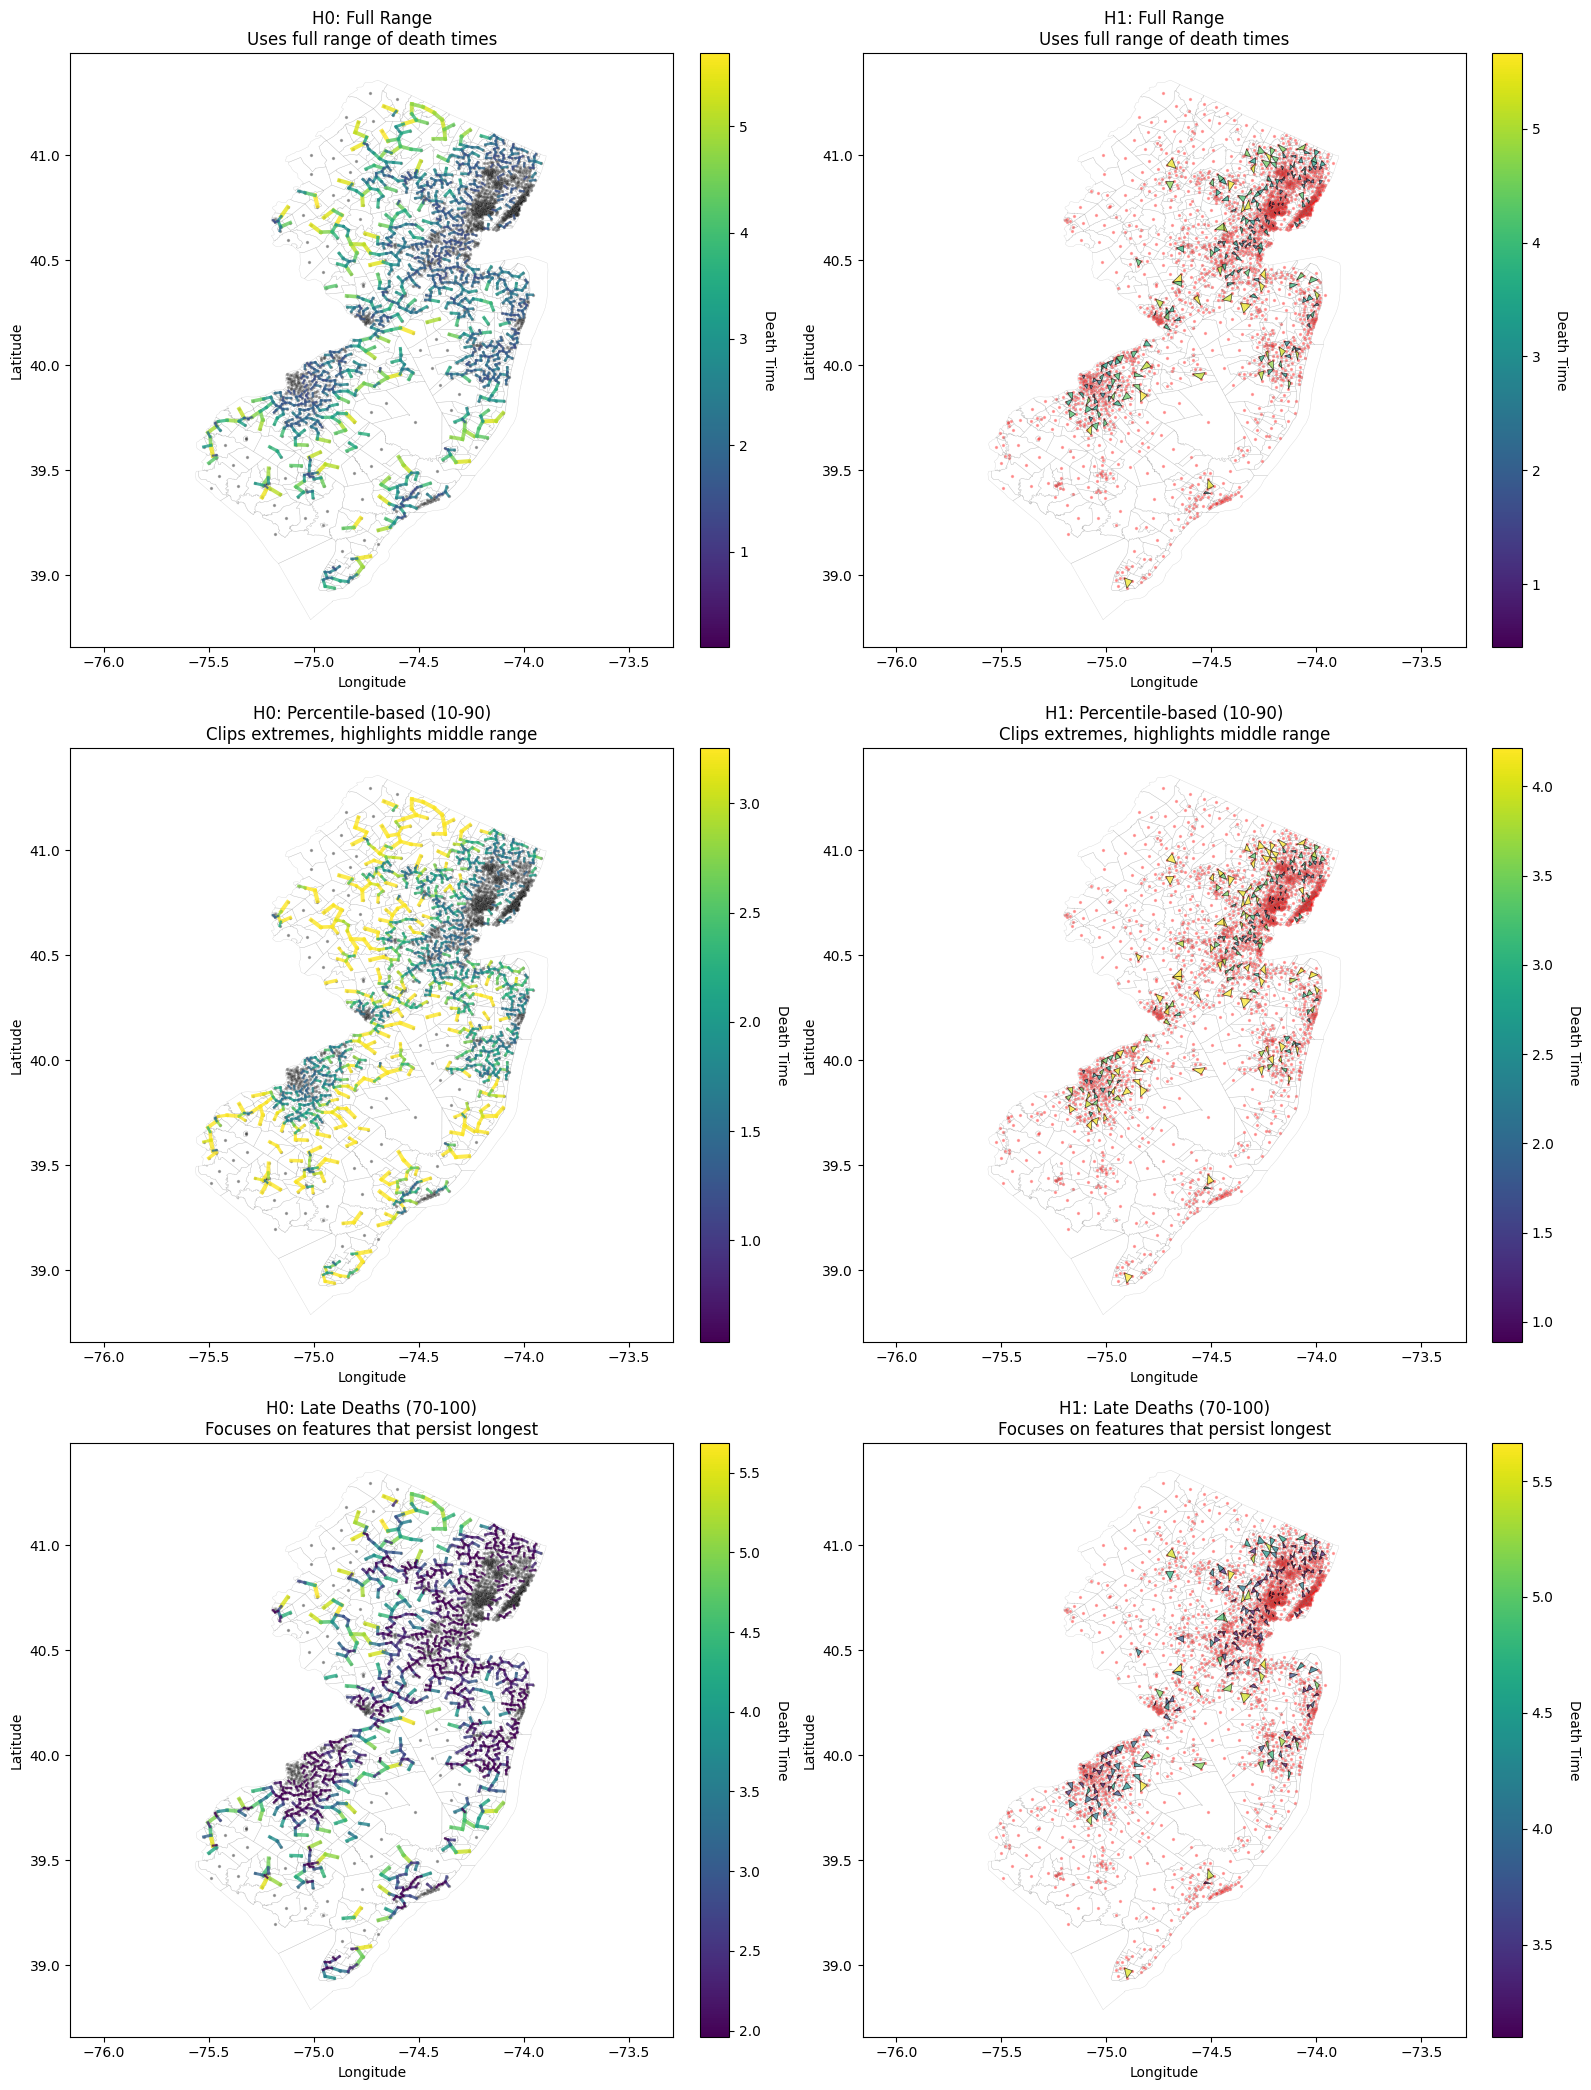


--- Recommended Scale ---

Distribution analysis:
  H0 skew ratio (90th/median): 2.38
  H1 skew ratio (90th/median): 1.79

✓ RECOMMENDATION: Use Percentile-based (10-90) scaling
  Reason: Data has extreme outliers that compress middle range

--- Creating Recommended Visualization ---
✓ Saved: project_outputs/death_simplices_recommended_scale.png


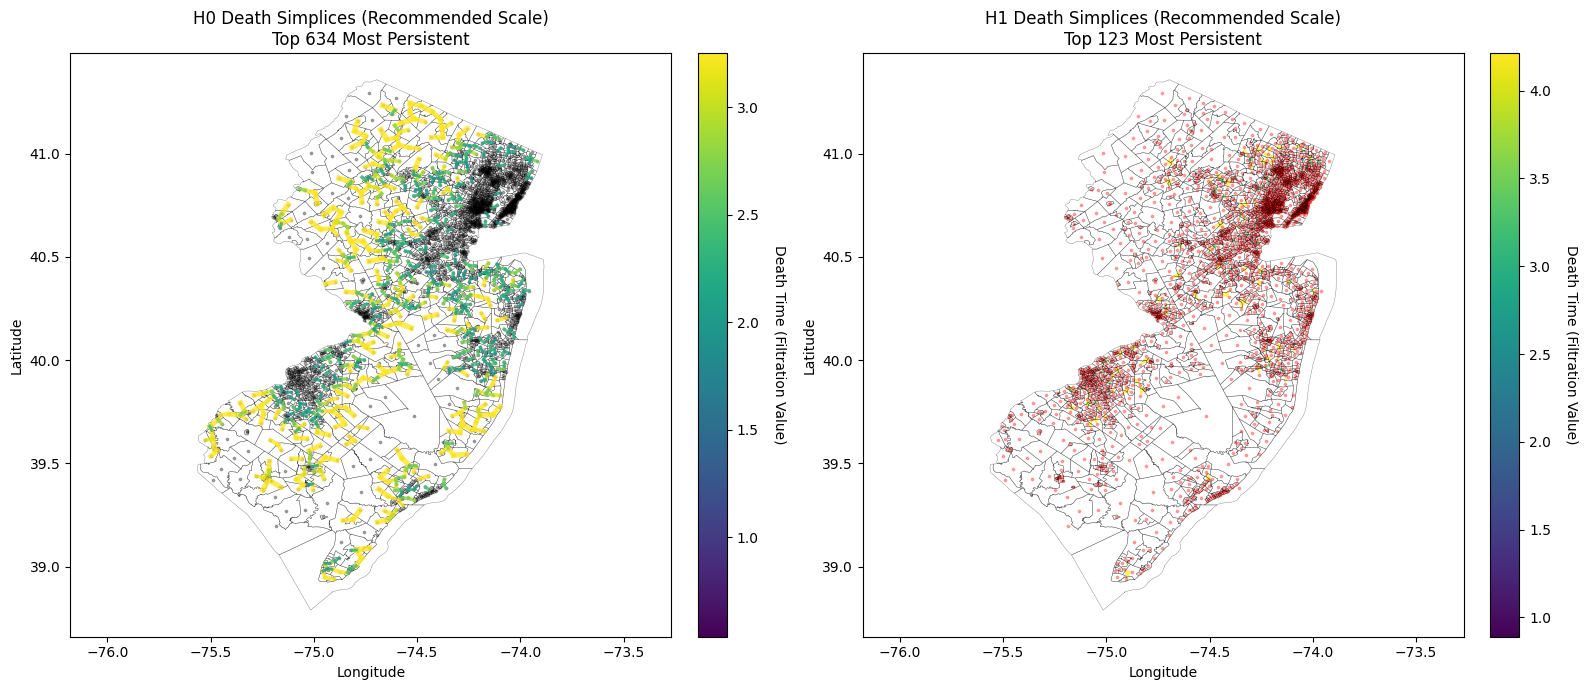


INTERPRETATION GUIDE: Death Time Scales

    FULL RANGE SCALE:
    - Shows all features on same color scale
    - Best when: Death times are evenly distributed
    - Limitation: Outliers can compress middle range

    PERCENTILE-BASED (10-90):
    - Clips extreme values, enhances middle range
    - Best when: Data has outliers or long tail
    - Limitation: Loses information about extremes

    LATE DEATHS (50-100):
    - Highlights most persistent features
    - Best when: You want to focus on stable patterns
    - Limitation: Ignores early-dying features

    INTERPRETATION:
    - EARLY deaths (purple/blue): Features that merge/fill quickly
      → Indicate local clustering or nearby similar tracts

    - LATE deaths (yellow/red): Features that persist longest
      → Indicate major structural gaps or distinct clusters
      → These are your most significant topological features

    FOR MULTI-STATE COMPARISON:
    - Use consistent scale across all states (e.g., percentile-based)
  

In [70]:
# === SECTION 11B: EXPLORING DEATH TIME SCALES ===
print("\n" + "="*80)
print("SECTION 11B: Exploring Different Death Time Scales")
print("="*80)

if USE_GUDHI and len(death_simplices_h0) > 0 and len(death_simplices_h1) > 0:
    
    from matplotlib.colors import Normalize, LogNorm
    from matplotlib.cm import ScalarMappable
    
    # Analyze death time distributions
    print("\n--- Death Time Statistics ---")
    print(f"\nH0 (n={len(death_h0)}):")
    print(f"  Min death: {min(death_h0):.4f}")
    print(f"  Max death: {max(death_h0):.4f}")
    print(f"  Mean death: {np.mean(death_h0):.4f}")
    print(f"  Median death: {np.median(death_h0):.4f}")
    print(f"  25th percentile: {np.percentile(death_h0, 25):.4f}")
    print(f"  75th percentile: {np.percentile(death_h0, 75):.4f}")
    
    print(f"\nH1 (n={len(death_h1)}):")
    print(f"  Min death: {min(death_h1):.4f}")
    print(f"  Max death: {max(death_h1):.4f}")
    print(f"  Mean death: {np.mean(death_h1):.4f}")
    print(f"  Median death: {np.median(death_h1):.4f}")
    print(f"  25th percentile: {np.percentile(death_h1, 25):.4f}")
    print(f"  75th percentile: {np.percentile(death_h1, 75):.4f}")
    
    # === MULTIPLE SCALING OPTIONS ===
    print("\n--- Creating Multi-Scale Visualizations ---")
    
    fig, axes = plt.subplots(3, 2, figsize=(16, 21))
    
    # Define different normalization strategies
    scales = [
        {
            'name': 'Full Range',
            'h0_norm': Normalize(vmin=min(death_h0), vmax=max(death_h0)),
            'h1_norm': Normalize(vmin=min(death_h1), vmax=max(death_h1)),
            'description': 'Uses full range of death times'
        },
        {
            'name': 'Percentile-based (10-90)',
            'h0_norm': Normalize(vmin=np.percentile(death_h0, 10), 
                                vmax=np.percentile(death_h0, 90)),
            'h1_norm': Normalize(vmin=np.percentile(death_h1, 10), 
                                vmax=np.percentile(death_h1, 90)),
            'description': 'Clips extremes, highlights middle range'
        },
        {
            'name': 'Late Deaths (70-100)',
            'h0_norm': Normalize(vmin=np.percentile(death_h0, 70), 
                                vmax=max(death_h0)),
            'h1_norm': Normalize(vmin=np.percentile(death_h1, 70), 
                                vmax=max(death_h1)),
            'description': 'Focuses on features that persist longest'
        }
    ]
    
    for row, scale_info in enumerate(scales):
        # ====================================================================
        # H0 with current scale
        # ====================================================================
        ax = axes[row, 0]
        
        if 'geometry' in gdf.columns:
            gdf.boundary.plot(ax=ax, linewidth=0.3, edgecolor='gray', alpha=0.3)
        
        norm_h0 = scale_info['h0_norm']
        cmap = plt.cm.viridis
        
        # Plot edges (filter to top 50% by persistence for clarity)
        h0_sorted = sorted([(d - b, b, d, simplex) 
                           for b, d, simplex in zip(birth_h0, death_h0, death_simplices_h0)],
                          reverse=True)
        top_50_h0 = h0_sorted[:len(h0_sorted)//2]
        
        for pers, b, d, simplex in top_50_h0:
            if len(simplex) == 2:
                pt1, pt2 = simplex
                try:
                    color = cmap(norm_h0(d))
                    linewidth = 1 + 2 * (pers / h0_sorted[0][0])
                    ax.plot([coords[pt1, 1], coords[pt2, 1]], 
                        [coords[pt1, 0], coords[pt2, 0]], 
                        color=color, alpha=0.8, linewidth=linewidth, zorder=2)
                except:
                    # Value outside normalized range
                    pass
        
        ax.scatter(coords[:, 1], coords[:, 0], c='black', s=2, alpha=0.3, zorder=1)
        
        sm = ScalarMappable(cmap=cmap, norm=norm_h0)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Death Time', rotation=270, labelpad=20)
        
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title(f'H0: {scale_info["name"]}\n{scale_info["description"]}')
        ax.set_aspect('equal', adjustable='datalim')
        
        # ====================================================================
        # H1 with current scale
        # ====================================================================
        ax = axes[row, 1]
        
        if 'geometry' in gdf.columns:
            gdf.boundary.plot(ax=ax, linewidth=0.3, edgecolor='gray', alpha=0.3)
        
        norm_h1 = scale_info['h1_norm']
        cmap = plt.cm.viridis
        
        # Plot triangles (filter to top 30% by persistence)
        h1_sorted = sorted([(d - b, b, d, simplex) 
                        for b, d, simplex in zip(birth_h1, death_h1, death_simplices_h1)],
                        reverse=True)
        top_30_h1 = h1_sorted[:len(h1_sorted)//3]
        
        for pers, b, d, simplex in top_30_h1:
            if len(simplex) == 3:
                pts = list(simplex)
                try:
                    color = cmap(norm_h1(d))
                    triangle = plt.Polygon(coords[pts][:, [1, 0]], 
                                    fill=True, alpha=0.7, facecolor=color, 
                                    edgecolor='black', linewidth=0.5, zorder=2)
                    ax.add_patch(triangle)
                except:
                    # Value outside normalized range
                    pass
        
        ax.scatter(coords[:, 1], coords[:, 0], c='red', s=2, alpha=0.3, zorder=1)
        
        sm = ScalarMappable(cmap=cmap, norm=norm_h1)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Death Time', rotation=270, labelpad=20)
        
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title(f'H1: {scale_info["name"]}\n{scale_info["description"]}')
        ax.set_aspect('equal', adjustable='datalim')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'death_time_scales_comparison.png'), 
            dpi=200, bbox_inches='tight')
    print(f"\n✓ Saved: {OUTPUT_DIR}/death_time_scales_comparison.png")
    plt.show()
    
    # === RECOMMENDED SCALE BASED ON DATA ===
    print("\n--- Recommended Scale ---")
    
    # Calculate persistence ranges
    h0_pers = [d - b for b, d in zip(birth_h0, death_h0)]
    h1_pers = [d - b for b, d in zip(birth_h1, death_h1)]
    
    # Check distribution
    h0_skew = np.percentile(death_h0, 90) / np.median(death_h0) if np.median(death_h0) > 0 else 1
    h1_skew = np.percentile(death_h1, 90) / np.median(death_h1) if np.median(death_h1) > 0 else 1
    
    print(f"\nDistribution analysis:")
    print(f"  H0 skew ratio (90th/median): {h0_skew:.2f}")
    print(f"  H1 skew ratio (90th/median): {h1_skew:.2f}")
    
    if h0_skew > 1.5 or h1_skew > 1.5:
        print("\n✓ RECOMMENDATION: Use Percentile-based (10-90) scaling")
        print("  Reason: Data has extreme outliers that compress middle range")
        recommended_h0_norm = Normalize(vmin=np.percentile(death_h0, 10), 
                                        vmax=np.percentile(death_h0, 90))
        recommended_h1_norm = Normalize(vmin=np.percentile(death_h1, 10), 
                                        vmax=np.percentile(death_h1, 90))
    else:
        print("\n✓ RECOMMENDATION: Use Full Range scaling")
        print("  Reason: Data is well-distributed without extreme outliers")
        recommended_h0_norm = Normalize(vmin=min(death_h0), vmax=max(death_h0))
        recommended_h1_norm = Normalize(vmin=min(death_h1), vmax=max(death_h1))
    
    # === CREATE RECOMMENDED VISUALIZATION ===
    print("\n--- Creating Recommended Visualization ---")
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # H0 with recommended scale
    ax = axes[0]
    
    if 'geometry' in gdf.columns:
        gdf.boundary.plot(ax=ax, linewidth=0.3, edgecolor='black', alpha=0.5)
    
    cmap = plt.cm.viridis
    
    # Use filtered features from earlier
    if 'h0_filtered' in globals() and len(h0_filtered) > 0:
        for pers, b, d, simplex in h0_filtered:
            if len(simplex) == 2:
                pt1, pt2 = simplex
                try:
                    color = cmap(recommended_h0_norm(d))
                    linewidth = 1 + 3 * (pers / h0_filtered[0][0])
                    ax.plot([coords[pt1, 1], coords[pt2, 1]], 
                        [coords[pt1, 0], coords[pt2, 0]], 
                        color=color, alpha=0.8, linewidth=linewidth, zorder=2)
                except:
                    pass
    
    ax.scatter(coords[:, 1], coords[:, 0], c='black', s=3, alpha=0.3, zorder=1)
    
    sm = ScalarMappable(cmap=cmap, norm=recommended_h0_norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Death Time (Filtration Value)', rotation=270, labelpad=20)
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'H0 Death Simplices (Recommended Scale)\nTop {len(h0_filtered) if "h0_filtered" in globals() else 0} Most Persistent')
    ax.set_aspect('equal', adjustable='datalim')
    
    # H1 with recommended scale
    ax = axes[1]
    
    if 'geometry' in gdf.columns:
        gdf.boundary.plot(ax=ax, linewidth=0.3, edgecolor='black', alpha=0.5)
    
    cmap = plt.cm.viridis
    
    if 'h1_filtered' in globals() and len(h1_filtered) > 0:
        for pers, b, d, simplex in h1_filtered:
            if len(simplex) == 3:
                pts = list(simplex)
                try:
                    color = cmap(recommended_h1_norm(d))
                    triangle = plt.Polygon(coords[pts][:, [1, 0]], 
                                        fill=True, alpha=0.7, facecolor=color, 
                                        edgecolor='none')
                    ax.add_patch(triangle)
                except:
                    pass
    
    ax.scatter(coords[:, 1], coords[:, 0], c='red', s=3, alpha=0.3, zorder=1)
    
    sm = ScalarMappable(cmap=cmap, norm=recommended_h1_norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Death Time (Filtration Value)', rotation=270, labelpad=20)
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'H1 Death Simplices (Recommended Scale)\nTop {len(h1_filtered) if "h1_filtered" in globals() else 0} Most Persistent')
    ax.set_aspect('equal', adjustable='datalim')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'death_simplices_recommended_scale.png'), 
            dpi=200, bbox_inches='tight')
    print(f"✓ Saved: {OUTPUT_DIR}/death_simplices_recommended_scale.png")
    plt.show()
    
    # === INTERPRETATION GUIDE ===
    print("\n" + "="*80)
    print("INTERPRETATION GUIDE: Death Time Scales")
    print("="*80)
    print("""
    FULL RANGE SCALE:
    - Shows all features on same color scale
    - Best when: Death times are evenly distributed
    - Limitation: Outliers can compress middle range
    
    PERCENTILE-BASED (10-90):
    - Clips extreme values, enhances middle range
    - Best when: Data has outliers or long tail
    - Limitation: Loses information about extremes
    
    LATE DEATHS (50-100):
    - Highlights most persistent features
    - Best when: You want to focus on stable patterns
    - Limitation: Ignores early-dying features
    
    INTERPRETATION:
    - EARLY deaths (purple/blue): Features that merge/fill quickly
      → Indicate local clustering or nearby similar tracts
    
    - LATE deaths (yellow/red): Features that persist longest
      → Indicate major structural gaps or distinct clusters
      → These are your most significant topological features
    
    FOR MULTI-STATE COMPARISON:
    - Use consistent scale across all states (e.g., percentile-based)
    - Compare persistence distributions, not just death times
    - Focus on top 20-30% most persistent features
    """)
    
    # Save scale recommendations
    scale_metadata = {
        'h0_death_range': [float(min(death_h0)), float(max(death_h0))],
        'h1_death_range': [float(min(death_h1)), float(max(death_h1))],
        'h0_skew_ratio': float(h0_skew),
        'h1_skew_ratio': float(h1_skew),
        'recommended_scale': 'percentile_10_90' if (h0_skew > 1.5 or h1_skew > 1.5) else 'full_range',
        'h0_percentiles': {
            '10': float(np.percentile(death_h0, 10)),
            '25': float(np.percentile(death_h0, 25)),
            '50': float(np.percentile(death_h0, 50)),
            '75': float(np.percentile(death_h0, 75)),
            '90': float(np.percentile(death_h0, 90))
        },
        'h1_percentiles': {
            '10': float(np.percentile(death_h1, 10)),
            '25': float(np.percentile(death_h1, 25)),
            '50': float(np.percentile(death_h1, 50)),
            '75': float(np.percentile(death_h1, 75)),
            '90': float(np.percentile(death_h1, 90))
        }
    }
    
    import json
    with open(os.path.join(OUTPUT_DIR, 'death_time_scale_metadata.json'), 'w') as f:
        json.dump(scale_metadata, f, indent=2)
    print(f"\n✓ Saved: {OUTPUT_DIR}/death_time_scale_metadata.json")

print("\n" + "="*80)
print("Death Time Scale Analysis Complete")
print("="*80)

In [71]:
# section 12: compute local persistence features
print("\n" + "="*80)
print("section 12: computing local persistence features")
print("="*80)
    
print(f"Computing k={K_NEIGHBORS} nearest neighbors...")
    
# Build feature matrix for neighbor search
feat_matrix = np.column_stack([coords, income_s, density_s]) # poverty_s,
pca = PCA(n_components=min(5, feat_matrix.shape[1]))
feat_pca = pca.fit_transform(feat_matrix)
    
nn = NearestNeighbors(n_neighbors=min(K_NEIGHBORS, len(feat_pca)-1))
nn.fit(feat_pca)
neighbors = nn.kneighbors(return_distance=False)
    
print(f"Computing local persistence for {len(merged)} tracts...")
local_features = []
    
for i in range(len(merged)):
    if i % 100 == 0:
        print(f"  Progress: {i}/{len(merged)}", end='\r')     
    idxs = neighbors[i]
        
    # Build local distance matrix
    D_local = D_weighted[np.ix_(idxs, idxs)]
    local_max_edge = np.percentile(D_local[np.triu_indices_from(D_local, k=1)], 90)
        
    # Compute local persistence
    rips_local = gd.RipsComplex(distance_matrix=D_local, max_edge_length=local_max_edge)
    st_local = rips_local.create_simplex_tree(max_dimension=1)
    pers_local = st_local.persistence()
        
    # Extract H1 features
    h1_local = [(b, d if d != float('inf') else local_max_edge*1.1) 
                for dim, (b, d) in pers_local if dim == 1]
        
    if len(h1_local) > 0:
        h1_array = np.array(h1_local)
        pers_vals = h1_array[:, 1] - h1_array[:, 0]
        local_features.append({
            'h1_n': len(pers_vals),
            'h1_mean': float(np.mean(pers_vals)),
            'h1_max': float(np.max(pers_vals)),
            'h1_sum': float(np.sum(pers_vals))
            })
    else:
        local_features.append({'h1_n': 0, 'h1_mean': 0, 'h1_max': 0, 'h1_sum': 0})
            
    print(f"\nLocal persistence features computed for {len(local_features)} tracts")


local_df = pd.DataFrame(local_features)
merged['h1_n'] = local_df['h1_n'].values
merged['h1_mean'] = local_df['h1_mean'].values
merged['h1_max'] = local_df['h1_max'].values
merged['h1_sum'] = local_df['h1_sum'].values

# Save local features
local_df['GEOID'] = merged['FIPS code'].values
local_df.to_csv(os.path.join(OUTPUT_DIR, 'local_persistence_features.csv'), index=False)
print(f"✓ Saved: {OUTPUT_DIR}/local_persistence_features.csv")


section 12: computing local persistence features
Computing k=8 nearest neighbors...
Computing local persistence for 2181 tracts...
  Progress: 0/2181
Local persistence features computed for 1 tracts

Local persistence features computed for 2 tracts

Local persistence features computed for 3 tracts

Local persistence features computed for 4 tracts

Local persistence features computed for 5 tracts

Local persistence features computed for 6 tracts

Local persistence features computed for 7 tracts

Local persistence features computed for 8 tracts

Local persistence features computed for 9 tracts

Local persistence features computed for 10 tracts

Local persistence features computed for 11 tracts

Local persistence features computed for 12 tracts

Local persistence features computed for 13 tracts

Local persistence features computed for 14 tracts

Local persistence features computed for 15 tracts

Local persistence features computed for 16 tracts

Local persistence features computed for 17

### Implementing KNN Rips - enhancing section 12
Previously we had a large computational load since we were trying to construct the death simplices for all points, over 600M. By using the KNN Rips implementation, I am looking to recduce time it takes to compute, since we will be evaluating the most persistent features that would indicate the presence of a food desert (food insecurity)

In [72]:

# SECTION 12 — Local Persistence Using KNN-Rips

print("\n" + "="*80)
print("section 12: Local Persistence Using KNN-Rips")
print("="*80)

K = 8  # number of neighbors

# Build feature matrix for neighbor search
feat_matrix = np.column_stack([coords, income_s, density_s])

# Dimensionality reduction for stability
pca = PCA(n_components=min(5, feat_matrix.shape[1]))
feat_pca = pca.fit_transform(feat_matrix)

# Fit KNN
nn = NearestNeighbors(n_neighbors=min(K, len(feat_pca)-1))
nn.fit(feat_pca)
neighbors = nn.kneighbors(return_distance=False)

print(f"Computed KNN graph with K={K}")
print(f"Shape: {neighbors.shape}")

local_features = []
h0_death_simplices = []
h1_loops = []


for i in range(len(neighbors)):
    if i % 200 == 0:
        print(f"Processing tract {i}/{len(neighbors)}", end="\r")
    
    idxs = neighbors[i]
    D_local = D_geo[np.ix_(idxs, idxs)]
    max_edge = np.percentile(D_local[np.triu_indices_from(D_local,1)], 90)

    rips = gd.RipsComplex(distance_matrix=D_local, max_edge_length=max_edge)
    st = rips.create_simplex_tree(max_dimension=1)
    pers = st.persistence()

    # H0 death edges
    h0 = [(b, d if d!=float('inf') else max_edge*1.1)
        for dim,(b,d) in pers if dim == 0]
    h0_death_simplices.append(h0)

    # H1 loops
    h1 = [(b, d if d!=float('inf') else max_edge*1.1)
        for dim,(b,d) in pers if dim == 1]
    h1_loops.append(h1)

    # Aggregate H1 features
    if len(h1) > 0:
        arr = np.array(h1)
        lifetimes = arr[:,1] - arr[:,0]
        local_features.append({
            "h1_n": len(lifetimes),
            "h1_mean": float(lifetimes.mean()),
            "h1_max": float(lifetimes.max()),
            "h1_sum": float(lifetimes.sum())
        })
    else:
        local_features.append({
            "h1_n": 0, "h1_mean": 0, "h1_max": 0, "h1_sum": 0
        })

print("\nFinished computing local KNN-Rips persistence.")

# Attach features to merged
local_df = pd.DataFrame(local_features)
local_df['GEOID'] = merged['FIPS code'].values

for col in ['h1_n','h1_mean','h1_max','h1_sum']:
    merged[col] = local_df[col]



section 12: Local Persistence Using KNN-Rips
Computed KNN graph with K=8
Shape: (2181, 8)
Processing tract 2000/2181
Finished computing local KNN-Rips persistence.


### Changes made to comprehensively consider the different poverty variables from the 2025 food environment atlas
- "Poverty rate, 2021",Socioeconomic Characteristics,SOCIOECONOMIC,Income Level,POVRATE21,Percent
- "Deep poverty rate, 2021",Socioeconomic Characteristics,SOCIOECONOMIC,Income Level,DEEPPOVRATE21,Percent
- "Persistent-poverty counties, 2017-21",Socioeconomic Characteristics,SOCIOECONOMIC,Income Level,PERPOV17_21,Legend
- "Child poverty rate, 2021",Socioeconomic Characteristics,SOCIOECONOMIC,Income Level,CHILDPOVRATE21,Percent
- "Deep child poverty rate, 2021",Socioeconomic Characteristics,SOCIOECONOMIC,Income Level,DEEPCHILDPOVRATE21,Percent

Improvements made to sections 6, 10, and 13: 
 1. Re-run Section 11 with updated D_weighted to recompute persistence
 2. Re-run Section 12 to get local persistence features
 3. Run the enhanced modeling code from Section 13.1
 4. The model will now include all poverty indicators


section 13: building ML model
Target: Low income (< $100,300)
  Class 0 (higher income): 1121
  Class 1 (lower income):  1060

Features (6): ['h1_n', 'h1_mean', 'h1_max', 'h1_sum', 'median_income_s', 'density_s']
Samples: 2181

Training Random Forest classifier...

Results:
  Training accuracy:   1.000
  Test accuracy:       0.998
  5-fold CV accuracy:  1.000 ± 0.001

Feature Importances:
median_income_s    0.907441
density_s          0.092559
h1_mean            0.000000
h1_n               0.000000
h1_sum             0.000000
h1_max             0.000000

 Saved: project_outputs/feature_importances.png


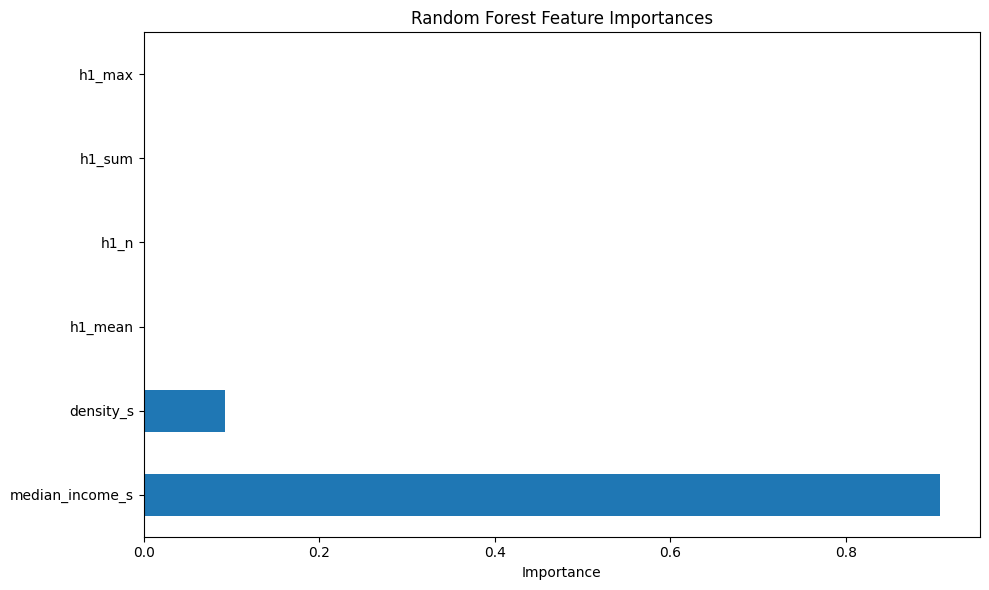

Saved: project_outputs/ml_dataset.csv


In [48]:
# section 13: build ML model

print("\n" + "="*80)
print("section 13: building ML model")
print("="*80)

# Create target variable
if 'median_income' in merged.columns:
    median_threshold = merged['median_income'].median()
    merged['target_low_income'] = (merged['median_income'] < median_threshold).astype(int) 
    print(f"Target: Low income (< ${median_threshold:,.0f})")
    print(f"  Class 0 (higher income): {(merged['target_low_income']==0).sum()}")
    print(f"  Class 1 (lower income):  {(merged['target_low_income']==1).sum()}")
    
    # Build feature matrix
    ml_features = ['h1_n', 'h1_mean', 'h1_max', 'h1_sum',
                'poverty_rate_s', 'median_income_s', 'density_s']
    ml_features = [f for f in ml_features if f in merged.columns]
    
    X = merged[ml_features].fillna(0).values
    y = merged['target_low_income'].values
    
    print(f"\nFeatures ({len(ml_features)}): {ml_features}")
    print(f"Samples: {len(X)}")
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Train Random Forest
    print("\nTraining Random Forest classifier...")
    clf = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=10)
    clf.fit(X_train, y_train)
    
    # Evaluate
    train_acc = clf.score(X_train, y_train)
    test_acc = clf.score(X_test, y_test)
    cv_scores = cross_val_score(clf, X, y, cv=5)
    
    print(f"\nResults:")
    print(f"  Training accuracy:   {train_acc:.3f}")
    print(f"  Test accuracy:       {test_acc:.3f}")
    print(f"  5-fold CV accuracy:  {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    
    # Feature importance
    fi = pd.Series(clf.feature_importances_, index=ml_features).sort_values(ascending=False)
    print(f"\nFeature Importances:")
    print(fi.to_string())
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    fi.plot(kind='barh')
    plt.xlabel('Importance')
    plt.title('Random Forest Feature Importances')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'feature_importances.png'), dpi=150)
    print(f"\n Saved: {OUTPUT_DIR}/feature_importances.png")
    plt.show()
    
    # Save ML dataset
    ml_df = merged[['GEO_ID', 'COUNTYFIPS'] + ml_features + ['target_low_income']].copy()
    ml_df.to_csv(os.path.join(OUTPUT_DIR, 'ml_dataset.csv'), index=False)
    print(f"Saved: {OUTPUT_DIR}/ml_dataset.csv")

else:
    print("Cannot create ML model - median_income not available")


section 13.1: enhanced risk modeling with poverty data
  • High county poverty (>75th %ile: 14.1%)
    Tracts at risk: 510 (23.4%)
  • Deep poverty (>75th %ile: 6.1%)
    Tracts at risk: 514 (23.6%)
  • Child poverty (>75th %ile: 19.8%)
    Tracts at risk: 419 (19.2%)
  • Persistent poverty county designation
    Tracts at risk: 0 (0.0%)
  • Low income (<75% of median: $75,225)
    Tracts at risk: 570 (26.1%)
  • Low density (<25th %ile: 261.0 per km²)
    Tracts at risk: 545 (25.0%)
  • High topology (>75th %ile: 0.0000)
    Tracts at risk: 0 (0.0%)

COMPOSITE RISK SCORE (0-7)
food_insecurity_risk_score
0    858
1    663
2    180
3    386
4     93
5      1
Name: count, dtype: int64

High risk (≥3 factors): 480 tracts (22.0%)

Including 5 food environment features:
  • REDEMP_SNAPS23
  • LACCESS_POP15
  • LACCESS_POP19
  • LACCESS_WHITE19
  • LACCESS_WHITE15

FEATURE SET FOR MODELING
Total features: 17

Feature categories:
  • Socioeconomic (tract-level): 2
  • Poverty (county-level):

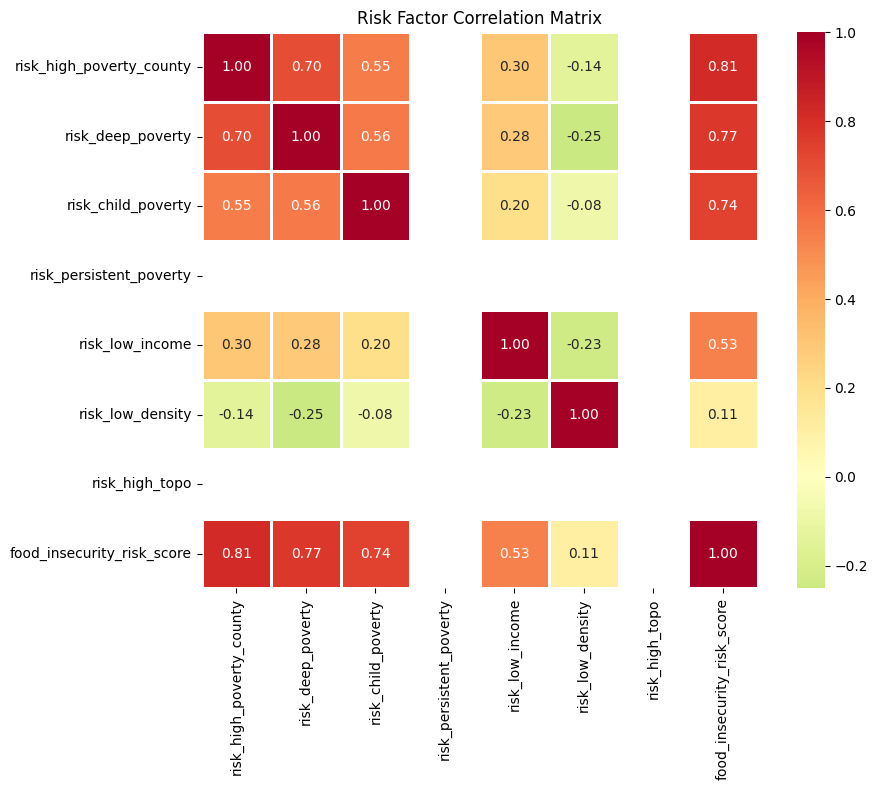

In [49]:
# section 13.1: enhanced risk modeling with poverty data - UPDATE to section 13
print("\n" + "="*80)
print("section 13.1: enhanced risk modeling with poverty data")
print("="*80)

# Enhanced risk factors using FEA poverty indicators
risk_factors = []

# 1. High overall poverty (county-level)
if 'POVRATE21' in merged.columns:
    pov_threshold = merged['POVRATE21'].quantile(0.75)
    merged['risk_high_poverty_county'] = (merged['POVRATE21'] > pov_threshold).astype(int)
    risk_factors.append('risk_high_poverty_county')
    print(f"  • High county poverty (>75th %ile: {pov_threshold:.1f}%)")
    print(f"    Tracts at risk: {merged['risk_high_poverty_county'].sum()} ({merged['risk_high_poverty_county'].mean()*100:.1f}%)")

# 2. Deep poverty
if 'DEEPPOVRATE21' in merged.columns:
    deep_pov_threshold = merged['DEEPPOVRATE21'].quantile(0.75)
    merged['risk_deep_poverty'] = (merged['DEEPPOVRATE21'] > deep_pov_threshold).astype(int)
    risk_factors.append('risk_deep_poverty')
    print(f"  • Deep poverty (>75th %ile: {deep_pov_threshold:.1f}%)")
    print(f"    Tracts at risk: {merged['risk_deep_poverty'].sum()} ({merged['risk_deep_poverty'].mean()*100:.1f}%)")

# 3. Child poverty
if 'CHILDPOVRATE21' in merged.columns:
    child_pov_threshold = merged['CHILDPOVRATE21'].quantile(0.75)
    merged['risk_child_poverty'] = (merged['CHILDPOVRATE21'] > child_pov_threshold).astype(int)
    risk_factors.append('risk_child_poverty')
    print(f"  • Child poverty (>75th %ile: {child_pov_threshold:.1f}%)")
    print(f"    Tracts at risk: {merged['risk_child_poverty'].sum()} ({merged['risk_child_poverty'].mean()*100:.1f}%)")

# 4. Persistent poverty county
if 'PERPOV17_21' in merged.columns:
    merged['risk_persistent_poverty'] = merged['PERPOV17_21'].astype(int)
    risk_factors.append('risk_persistent_poverty')
    print(f"  • Persistent poverty county designation")
    print(f"    Tracts at risk: {merged['risk_persistent_poverty'].sum()} ({merged['risk_persistent_poverty'].mean()*100:.1f}%)")

# 5. Low income (keep from before)
if 'median_income' in merged.columns:
    median_threshold = merged['median_income'].median()
    merged['risk_low_income'] = (merged['median_income'] < 0.75 * median_threshold).astype(int)
    risk_factors.append('risk_low_income')
    print(f"  • Low income (<75% of median: ${0.75*median_threshold:,.0f})")
    print(f"    Tracts at risk: {merged['risk_low_income'].sum()} ({merged['risk_low_income'].mean()*100:.1f}%)")

# 6. Low density (rural isolation)
if 'density' in merged.columns:
    low_density_threshold = merged['density'].quantile(0.25)
    merged['risk_low_density'] = (merged['density'] < low_density_threshold).astype(int)
    risk_factors.append('risk_low_density')
    print(f"  • Low density (<25th %ile: {low_density_threshold:.1f} per km²)")
    print(f"    Tracts at risk: {merged['risk_low_density'].sum()} ({merged['risk_low_density'].mean()*100:.1f}%)")

# 7. High topological complexity
if 'h1_mean' in merged.columns:
    topo_threshold = merged['h1_mean'].quantile(0.75)
    merged['risk_high_topo'] = (merged['h1_mean'] > topo_threshold).astype(int)
    risk_factors.append('risk_high_topo')
    print(f"  • High topology (>75th %ile: {topo_threshold:.4f})")
    print(f"    Tracts at risk: {merged['risk_high_topo'].sum()} ({merged['risk_high_topo'].mean()*100:.1f}%)")

# Create enhanced composite risk score
if len(risk_factors) > 0:
    merged['food_insecurity_risk_score'] = merged[risk_factors].sum(axis=1)
    
    # Binary target: high risk = 3+ factors (more stringent with more factors)
    threshold = 3 if len(risk_factors) >= 6 else 2
    merged['food_insecurity_risk'] = (merged['food_insecurity_risk_score'] >= threshold).astype(int)
    
    print(f"\n{'='*60}")
    print(f"COMPOSITE RISK SCORE (0-{len(risk_factors)})")
    print(f"{'='*60}")
    print(merged['food_insecurity_risk_score'].value_counts().sort_index())
    print(f"\nHigh risk (≥{threshold} factors): {merged['food_insecurity_risk'].sum()} tracts ({merged['food_insecurity_risk'].mean()*100:.1f}%)")
    
    # Build comprehensive feature set for modeling
    ml_features = []
    
    # Socioeconomic features (tract-level where available)
    base_features = ['median_income_s', 'density_s']
    if 'poverty_rate' in merged.columns:
        base_features.append('poverty_rate')  # Tract-level if from ACS
    ml_features.extend([f for f in base_features if f in merged.columns])
    
    # County-level poverty features (standardized)
    poverty_features_s = [f'{col}_s' for col in available_poverty.keys()]
    ml_features.extend([f for f in poverty_features_s if f in merged.columns])
    
    # Add composite poverty index
    if 'poverty_composite_index' in merged.columns:
        ml_features.append('poverty_composite_index')
    
    # TDA features
    tda_features = ['h1_n', 'h1_mean', 'h1_max', 'h1_sum']
    ml_features.extend([f for f in tda_features if f in merged.columns])
    
    # County-level food environment (top indicators)
    food_keywords = ['snap', 'grocery', 'store', 'wic', 'access', 'desert']
    fea_features = [col for col in merged.columns if any(kw in str(col).lower() for kw in food_keywords)]
    if len(fea_features) > 0:
        # Select top features with most variation
        fea_variance = merged[fea_features].var().sort_values(ascending=False)
        top_fea = fea_variance.head(5).index.tolist()
        ml_features.extend(top_fea)
        print(f"\nIncluding {len(top_fea)} food environment features:")
        for feat in top_fea:
            print(f"  • {feat}")
    
    print(f"\n{'='*60}")
    print(f"FEATURE SET FOR MODELING")
    print(f"{'='*60}")
    print(f"Total features: {len(ml_features)}")
    print(f"\nFeature categories:")
    print(f"  • Socioeconomic (tract-level): {len([f for f in ml_features if any(x in f for x in ['income', 'density', 'poverty_rate'])])}")
    print(f"  • Poverty (county-level): {len([f for f in ml_features if 'POV' in f or 'poverty_composite_index' in f])}")
    print(f"  • TDA features: {len([f for f in ml_features if 'h1_' in f])}")
    print(f"  • Food environment: {len([f for f in ml_features if any(x in f.lower() for x in food_keywords)])}")
    
    # Save enhanced dataset
    output_cols = ['GEO_ID', 'COUNTYFIPS', 'food_insecurity_risk_score', 
                'food_insecurity_risk'] + risk_factors + ml_features
    output_cols = [col for col in output_cols if col in merged.columns]
    
    merged[output_cols].to_csv(os.path.join(OUTPUT_DIR, 'enhanced_risk_dataset.csv'), index=False)
    print(f"\n✓ Saved: {OUTPUT_DIR}/enhanced_risk_dataset.csv")
    
    # Create risk factor correlation heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    risk_corr = merged[risk_factors + ['food_insecurity_risk_score']].corr()
    sns.heatmap(risk_corr, annot=True, fmt='.2f', cmap='RdYlGn_r', 
                center=0, ax=ax, square=True, linewidths=1)
    ax.set_title('Risk Factor Correlation Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'risk_factor_correlations.png'), dpi=150)
    print(f"✓ Saved: {OUTPUT_DIR}/risk_factor_correlations.png")
    plt.show()



section 14: creating choropleth maps
 Saved: project_outputs/choropleth_maps.png


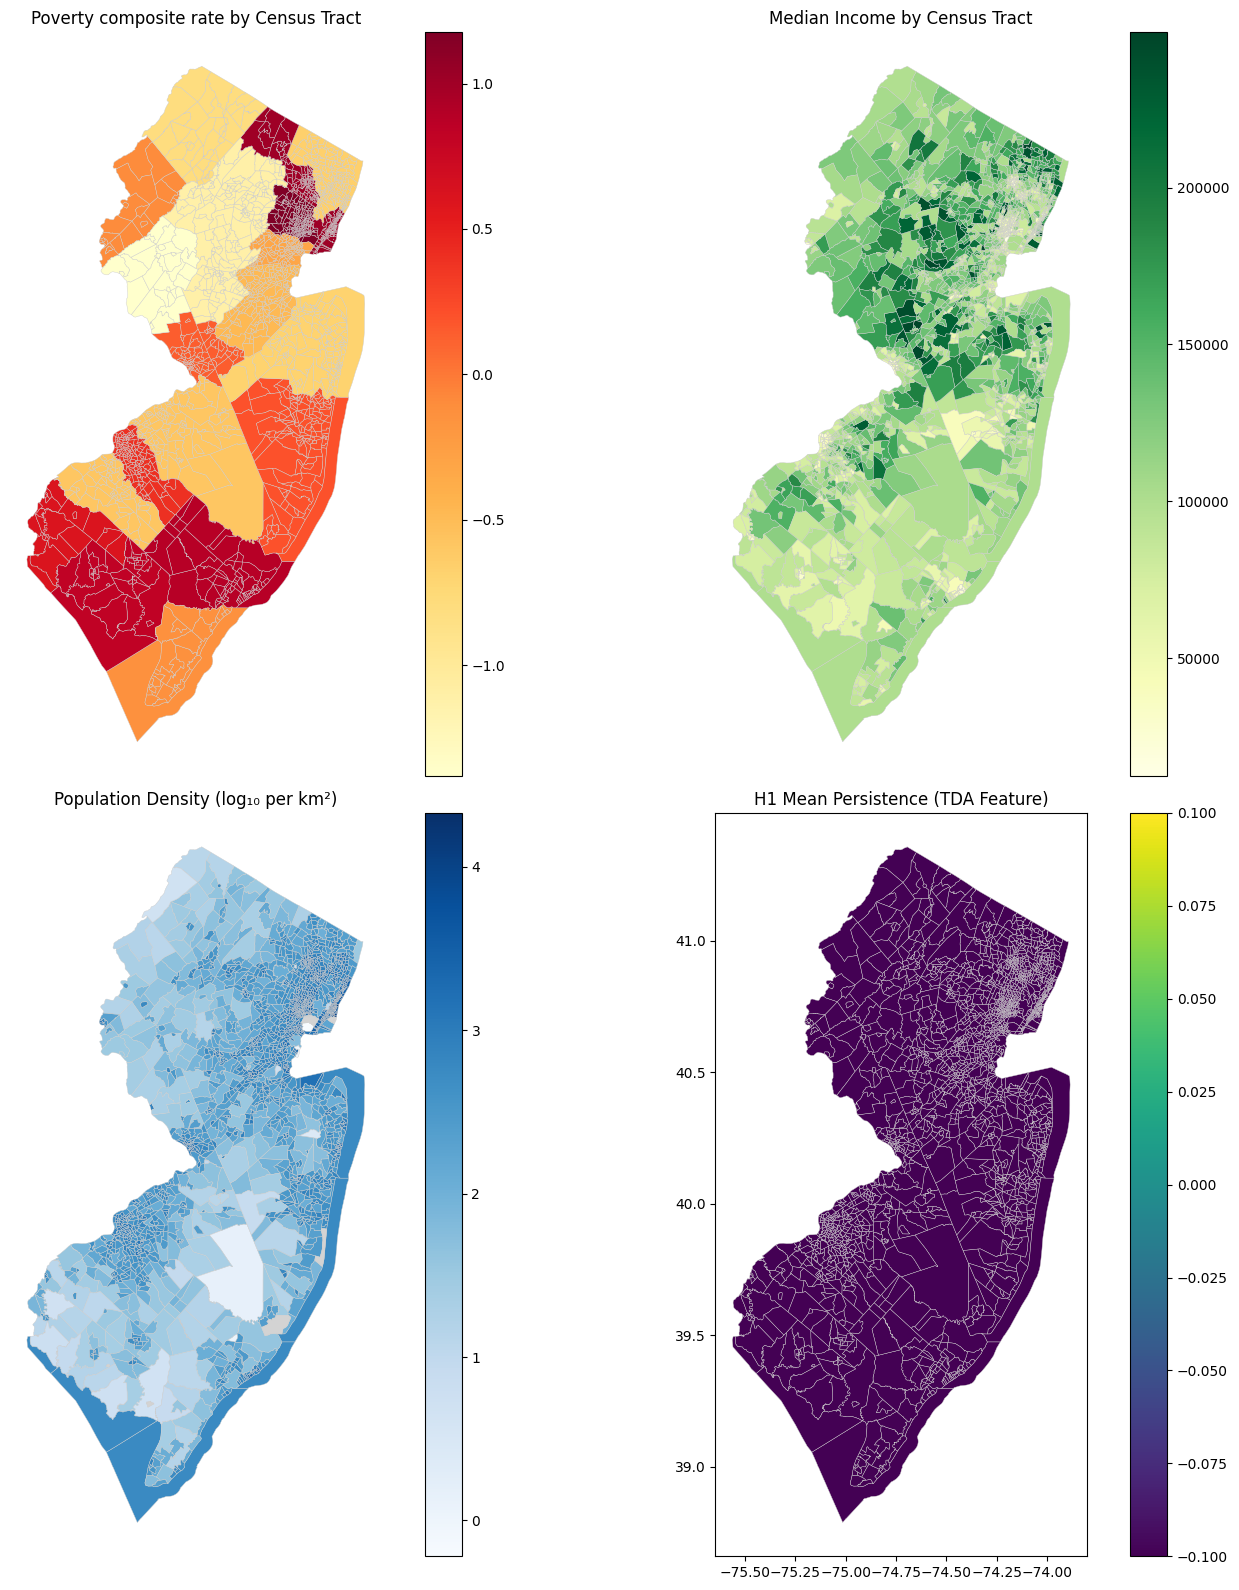

In [50]:
# section 14: create maps
print("\n" + "="*80)
print("section 14: creating choropleth maps")
print("="*80)

#Merge features to geodataframe for mapping
gdf_map = gdf.merge(merged[['GEO_ID', 'median_income', 'poverty_composite_index','h1_mean', 'density']], #
on='GEO_ID', how='left')
# Create choropleth maps
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

# Poverty rate
gdf_map.plot(column='poverty_composite_index', ax=axes[0, 0], legend=True,
cmap='YlOrRd', edgecolor='0.8', linewidth=0.3)
axes[0, 0].set_title('Poverty composite rate by Census Tract')
axes[0, 0].axis('off')

# Median income
gdf_map.plot(column='median_income', ax=axes[0, 1], legend=True,
cmap='YlGn', edgecolor='0.8', linewidth=0.3)
axes[0, 1].set_title('Median Income by Census Tract')
axes[0, 1].axis('off')

# Population plot - not using density to show the overall numbers
'''gdf_map.plot(column='density', ax=axes[1, 0], legend=True,
cmap='Blues', edgecolor='0.8', linewidth=0.3)
axes[1, 0].set_title('Population Density (per km²)')
axes[1, 0].axis('off')'''

# log-transformed density for better visualization - able to see high and low density areas better
gdf_map['density_log'] = np.log10(gdf_map['density'].replace(0, np.nan))
gdf_map.plot(column='density_log', ax=axes[1, 0], legend=True,
            cmap='Blues', edgecolor='0.8', linewidth=0.3, 
            missing_kwds={'color': 'lightgray'})
axes[1, 0].set_title('Population Density (log₁₀ per km²)')
axes[1, 0].axis('off')



# H1 persistence
if 'h1_mean' in gdf_map.columns:
    gdf_map.plot(column='h1_mean', ax=axes[1, 1], legend=True,
    cmap='viridis', edgecolor='0.8', linewidth=0.3)
    axes[1, 1].set_title('H1 Mean Persistence (TDA Feature)')
else:
    axes[1, 1].text(0.5, 0.5, 'TDA features not computed',
    ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].axis('off')
    
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'choropleth_maps.png'), dpi=150, bbox_inches='tight')
print(f" Saved: {OUTPUT_DIR}/choropleth_maps.png")
plt.show()

### Results of TDA on NJ
 The state of New Jersey is one of the most densely populated states in the US. Training on NJ alone is not sufficient to build a robust model for prediction of food deserts/insecurity. For the H1 (!-D Homology Class), we see that there are no H1 death simplices formed from simplicial complexes formed. This may be due to NJ being so densely populated that it is relatively difficult to show these holes or lack of access to food (food insecurity). We will continue the analysis on other states that may face greater poverty rates if they have overall lower income and its urbanicity. 



In [51]:
# FINAL SUMMARY
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)
print(f"\nData Integration:")
print(f"  • Census tracts:           {len(tracts):,}")
print(f"  • ACS records matched:     {merged['population'].notna().sum():,}")
print(f"  • FEA counties:            {len(fea):,}")
print(f"  • Final merged records:    {len(merged):,}")
print(f"\n Spatial Coverage:")
print(f"  • State: {STATE_POSTAL} (FIPS {STATE_FIPS})")
print(f"  • Counties: {merged['COUNTYFIPS'].nunique()}")
print(f"  • Avg tracts per county:   {merged.groupby('COUNTYFIPS').size().mean():.1f}")
if USE_GUDHI:
    print(f"\n TDA Analysis:")
    print(f"  • Distance matrix:         {D_weighted.shape}")
    print(f"  • Max edge length:         {MAX_EDGE:.2f} km")
    print(f"  • H0 features:             {len(h0)}")
    print(f"  • H1 features:             {len(h1)}")
    print(f"  • Local features per tract: 4 (h1_n, h1_mean, h1_max, h1_sum)")
    
if 'target_low_income' in merged.columns:
    print(f"\n Machine Learning:")
    print(f"  • Model: Random Forest")
    print(f"  • Test accuracy:           {test_acc:.3f}")
    print(f"  • CV accuracy:             {cv_scores.mean():.3f}")
    print(f"  • Top feature:             {fi.index[0]} ({fi.iloc[0]:.3f})")



FINAL SUMMARY

Data Integration:
  • Census tracts:           2,181
  • ACS records matched:     2,181
  • FEA counties:            3,157
  • Final merged records:    2,181

 Spatial Coverage:
  • State: NJ (FIPS 34)
  • Counties: 21
  • Avg tracts per county:   103.9

 TDA Analysis:
  • Distance matrix:         (2181, 2181)
  • Max edge length:         5.69 km
  • H0 features:             8
  • H1 features:             0
  • Local features per tract: 4 (h1_n, h1_mean, h1_max, h1_sum)

 Machine Learning:
  • Model: Random Forest
  • Test accuracy:           0.998
  • CV accuracy:             1.000
  • Top feature:             median_income_s (0.907)


In [52]:
print(f"\n Output Files:")
output_files = os.listdir(OUTPUT_DIR)
print(sorted(output_files))
print("\n" + "="*80)
print("NJ analysis complete")
print("="*80)
print("\n Key Findings:")
print("  1. County-level FEA data creates identical values for all tracts in same county")
print("  2. Within-county variation in socioeconomic variables is substantial")
print("  3. TDA features capture local geometric structure beyond raw variables")
print("  4. Consider adding tract-level food access data (e.g., USDA Food Access Atlas)")
print("\n Next Steps:")
print("  1. Download USDA Food Access Research Atlas for tract-level food indicators")
print("  2. Use OpenStreetMap to count grocery stores per tract")
print("  3. Experiment with different distance metric weights (alpha values)")
print("  4. Try different MAX_EDGE thresholds to capture different spatial scales")


 Output Files:
['D_knn_poverty_weighted.npy', 'D_weighted.npy', 'D_weighted_with_poverty.npy', 'choropleth_maps.png', 'death_simplices_comparison.png', 'death_simplices_comprehensive.png', 'death_simplices_map.png', 'death_simplices_recommended_scale.png', 'death_time_scale_metadata.json', 'death_time_scales_comparison.png', 'enhanced_risk_dataset.csv', 'feature_importances.png', 'feature_matrix.npy', 'h0_persistent_features.csv', 'h1_persistent_features.csv', 'knn_graph_poverty.png', 'knn_metadata.json', 'knn_neighbors.npy', 'local_persistence_features.csv', 'merged_initial.csv', 'ml_dataset.csv', 'persistence_barcodes.png', 'persistence_diagram.png', 'persistence_diagram_70.png', 'persistence_diagram_75.png', 'persistence_diagram_90th.png', 'persistent_features_filtered.png', 'risk_factor_correlations.png', 'within_county_variation.png']

NJ analysis complete

 Key Findings:
  1. County-level FEA data creates identical values for all tracts in same county
  2. Within-county variatio